#RISK BASED CUSTOMER SEGMENTATION




#Import

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Sample Code

In [ ]:
#sample_df = data.sample(n=500000, random_state=42)
#sample_df.head()
#sample_df.to_csv('sample_data5.csv', index=False)

#Data

The original dataset contains around 2.2 million records. Applying random sampling to downsize it to 100,000 rows.

In [ ]:
path = "/content/drive/MyDrive/Research Project/Dataset/sample_data.csv"

In [ ]:
data = pd.read_csv(path)
data.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0 NaN        NaN      35000        35000          35000.0   36 months   
1 NaN        NaN      30000        30000          30000.0   60 months   
2 NaN        NaN      15000        15000          15000.0   36 months   
3 NaN        NaN      24000        24000          24000.0   60 months   
4 NaN        NaN      14400        14400          14400.0   36 months   

   int_rate  installment grade sub_grade  ... hardship_payoff_balance_amount  \
0     12.12      1164.51     B        B3  ...                            NaN   
1     10.75       648.54     B        B4  ...                            NaN   
2      7.49       466.53     A        A4  ...                            NaN   
3     21.15       651.31     E        E2  ...                            NaN   
4      8.59       455.18     A        A5  ...                            NaN   

  hardship_last_payment_amount disbursement_method  debt_settlement_flag  \
0                          NaN                Cash                     N   
1                          NaN                Cash                     N   
2                          NaN                Cash                     N   
3                          NaN                Cash                     N   
4                          NaN                Cash                     N   

  debt_settlement_flag_date settlement_status settlement_date  \
0                       NaN               NaN             NaN   
1                       NaN               NaN             NaN   
2                       NaN               NaN             NaN   
3                       NaN               NaN             NaN   
4                       NaN               NaN             NaN   

  settlement_amount  settlement_percentage settlement_term  
0               NaN                    NaN             NaN  
1               NaN                    NaN             NaN  
2               NaN                    NaN             NaN  
3               NaN                    NaN             NaN  
4               NaN                    NaN             NaN  

[5 rows x 145 columns]

In [ ]:
df = data.copy()

In [ ]:
data.isnull().all().sum()

3

In [ ]:
#Columns having more than 50% missing values
threshold = 0.5*len(data)
miss_col = data.columns[data.isnull().sum() > threshold]
print(miss_col)
print(len(miss_col))

Index(['id', 'member_id', 'url', 'desc', 'mths_since_last_delinq',
       'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
       'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq',
       'revol_bal_joint', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util',
       'sec_app_open_act_il', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med',
       'sec_app_mths_since_last_major_derog', 'hardship_type',
       'hardship_reason', 'hardship_status', 'deferral_term',
       'hardship_amount', 'hardship_start_date', 'hardship_end_date',
       'payment_plan_start_date', 'hardship_length', 'hardship_dpd',
       'hardship_loan_status', 'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'd

In [ ]:
data.drop_duplicates(inplace=True)
len(data)

100000

In [ ]:
#Creating Dataframes for easier understanding of the data
df_1 = data.iloc[:, 0:15]
df_2 = data.iloc[:, 15:30]
df_3 = data.iloc[:, 30:45]
df_4 = data.iloc[:, 45:60]
df_5 = data.iloc[:, 60:75]
df_6 = data.iloc[:, 75:90]
df_7 = data.iloc[:, 90:105]
df_8 = data.iloc[:, 105:120]
df_9 = data.iloc[:, 120:135]
df_10 = data.iloc[:, 135:145]

df_1.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0 NaN        NaN      35000        35000          35000.0   36 months   
1 NaN        NaN      30000        30000          30000.0   60 months   
2 NaN        NaN      15000        15000          15000.0   36 months   
3 NaN        NaN      24000        24000          24000.0   60 months   
4 NaN        NaN      14400        14400          14400.0   36 months   

   int_rate  installment grade sub_grade                emp_title emp_length  \
0     12.12      1164.51     B        B3  Legacy Physicians Group   < 1 year   
1     10.75       648.54     B        B4      Director of nursing    2 years   
2      7.49       466.53     A        A4                  Partner    5 years   
3     21.15       651.31     E        E2    Einstein Bros. Bagels    5 years   
4      8.59       455.18     A        A5       Nurse practitioner    3 years   

  home_ownership  annual_inc verification_status  
0           RENT     90000.0            Verified  
1           RENT    100000.0            Verified  
2            OWN    100000.0     Source Verified  
3           RENT     58000.0     Source Verified  
4       MORTGAGE     90000.0        Not Verified

#Functions


In [ ]:
def drop_columns(df, columns_to_drop):
    df = df.drop(columns=columns_to_drop, axis=1)
    return df

In [ ]:
def convert_int_to_float(df):
    int_columns = df.select_dtypes(include='int64').columns
    df[int_columns] = df[int_columns].astype('float64')
    return df

In [ ]:
def convert_obj_to_string(df):
    obj_columns = df.select_dtypes(include='object').columns
    df[obj_columns] = df[obj_columns].astype('string')
    return df

In [ ]:
def convert_string_to_float(df):
    string_columns = df.select_dtypes(include='string').columns
    df[string_columns] = df[string_columns].apply(pd.to_numeric, errors='coerce')
    return df

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
def cramers_v(col1, col2):
    contingency_table = pd.crosstab(col1, col2)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    v = np.sqrt(chi2 / (n * min_dim))

    return v

def check_association(df):
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    associations = {}
    for col1 in categorical_cols:
        for col2 in categorical_cols:
            if col1 != col2:
                association_value = cramers_v(df[col1], df[col2])
                associations[(col1, col2)] = association_value

    return associations

In [ ]:
def clean_emp_length(df, column_name):
  def process_length(val):
    if pd.isnull(val):
      return val
    return ' '.join(val.split()[:-1])

  df[column_name] = df[column_name].apply(process_length)
  return df

In [ ]:
#In every data frame trying to remove columns using association and correlation

#DF_1

In [ ]:
df_1.dtypes

id                     float64
member_id              float64
loan_amnt                int64
funded_amnt              int64
funded_amnt_inv        float64
term                    object
int_rate               float64
installment            float64
grade                   object
sub_grade               object
emp_title               object
emp_length              object
home_ownership          object
annual_inc             float64
verification_status     object
dtype: object

In [ ]:
df_1.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status'],
      dtype='object')

In [ ]:
df_1['verification_status'].value_counts()

verification_status
Source Verified    38997
Not Verified       32824
Verified           28179
Name: count, dtype: int64

In [ ]:
df_1['home_ownership'].value_counts()

home_ownership
MORTGAGE    48843
RENT        39950
OWN         11169
ANY            29
OTHER           6
NONE            3
Name: count, dtype: int64

In [ ]:
df_1.isnull().sum()

id                     100000
member_id              100000
loan_amnt                   0
funded_amnt                 0
funded_amnt_inv             0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title                7473
emp_length               6562
home_ownership              0
annual_inc                  0
verification_status         0
dtype: int64

In [ ]:
df_1['emp_title'].value_counts() #not related

emp_title
Teacher                            1765
Manager                            1541
Owner                               945
Registered Nurse                    750
RN                                  687
                                   ... 
Certified Nurse                       1
Sr. Managed Services Consultant       1
A&p mechanic                          1
Sr. accounting manager                1
Product Management Coordniator        1
Name: count, Length: 41348, dtype: int64

In [ ]:
df_1.drop(['id','member_id','emp_title'],axis=1,inplace=True)

In [ ]:
df_1['term']=df_1['term'].str.split(" ").str[1]

In [ ]:
df_1['term']

0        36
1        60
2        36
3        60
4        36
         ..
99995    36
99996    60
99997    60
99998    36
99999    36
Name: term, Length: 100000, dtype: object

In [ ]:
df_1['term']=df_1['term'].astype('float64')

In [ ]:
df_1['term'].value_counts()

term
36.0    71443
60.0    28557
Name: count, dtype: int64

In [ ]:
df_1['emp_length'].value_counts()

emp_length
10+ years    33040
2 years       8961
< 1 year      8443
3 years       8026
1 year        6484
5 years       6152
4 years       6016
6 years       4650
7 years       4128
8 years       4036
9 years       3502
Name: count, dtype: int64

In [ ]:
convert_int_to_float(df_1)
df_1.dtypes

loan_amnt              float64
funded_amnt            float64
funded_amnt_inv        float64
term                   float64
int_rate               float64
installment            float64
grade                   object
sub_grade               object
emp_length              object
home_ownership          object
annual_inc             float64
verification_status     object
dtype: object

In [ ]:
df_1.head()

loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment grade  \
0    35000.0      35000.0          35000.0  36.0     12.12      1164.51     B   
1    30000.0      30000.0          30000.0  60.0     10.75       648.54     B   
2    15000.0      15000.0          15000.0  36.0      7.49       466.53     A   
3    24000.0      24000.0          24000.0  60.0     21.15       651.31     E   
4    14400.0      14400.0          14400.0  36.0      8.59       455.18     A   

  sub_grade emp_length home_ownership  annual_inc verification_status  
0        B3   < 1 year           RENT     90000.0            Verified  
1        B4    2 years           RENT    100000.0            Verified  
2        A4    5 years            OWN    100000.0     Source Verified  
3        E2    5 years           RENT     58000.0     Source Verified  
4        A5    3 years       MORTGAGE     90000.0        Not Verified

In [ ]:
#missing values

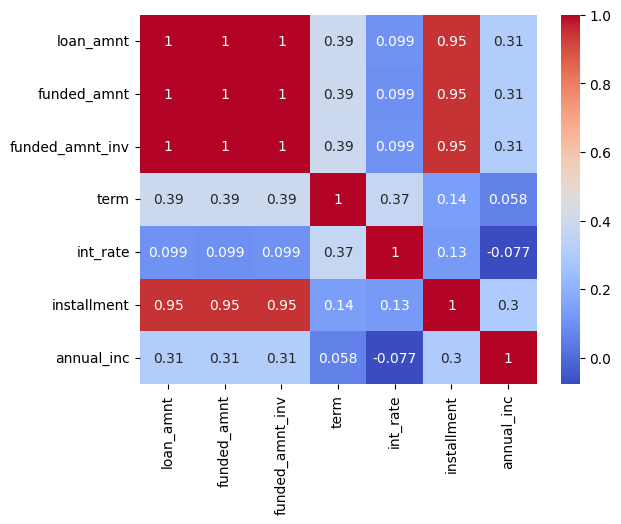

In [ ]:
correlation_matrix = df_1.select_dtypes(include='float64').corr()  # Calculate the correlation matrix

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
associations = check_association(df_1.select_dtypes(include='object'))
print(associations)

{('grade', 'sub_grade'): 1.0, ('grade', 'emp_length'): 0.012489749065844283, ('grade', 'home_ownership'): 0.03916833361955061, ('grade', 'verification_status'): 0.18042324783564573, ('sub_grade', 'grade'): 1.0, ('sub_grade', 'emp_length'): 0.019713490464627677, ('sub_grade', 'home_ownership'): 0.04634394034085503, ('sub_grade', 'verification_status'): 0.19461676114951712, ('emp_length', 'grade'): 0.012489749065844283, ('emp_length', 'sub_grade'): 0.019713490464627677, ('emp_length', 'home_ownership'): 0.09223929428545118, ('emp_length', 'verification_status'): 0.0383948301583145, ('home_ownership', 'grade'): 0.03916833361955061, ('home_ownership', 'sub_grade'): 0.04634394034085503, ('home_ownership', 'emp_length'): 0.09223929428545118, ('home_ownership', 'verification_status'): 0.03291954897207505, ('verification_status', 'grade'): 0.18042324783564573, ('verification_status', 'sub_grade'): 0.19461676114951712, ('verification_status', 'emp_length'): 0.0383948301583145, ('verification_st

In [ ]:
columns_to_remove = ['funded_amnt', 'funded_amnt_inv','sub_grade']
df_1 = drop_columns(df_1, columns_to_remove)

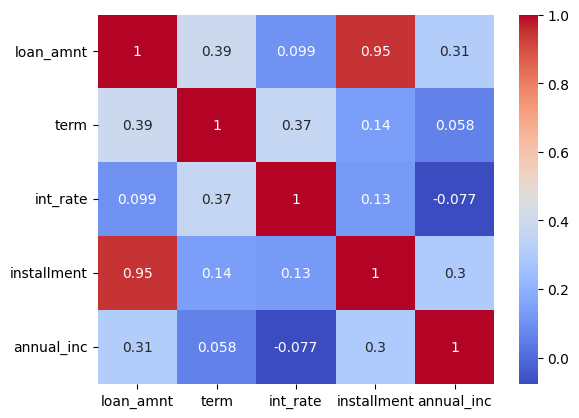

In [ ]:
correlation_matrix = df_1.select_dtypes(include='float64').corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
# drop --> id, member_id, emp_title,
# what is funded_amnt_inv?
# term --> object --> int64
# home_ownership --> drop --> Any Other None
# what is verifiation status and if it is regarding the data then verification_status --> drop --> Not Verified
# What to do with emp_length

In [ ]:
df_1.head()

loan_amnt  term  int_rate  installment grade emp_length home_ownership  \
0    35000.0  36.0     12.12      1164.51     B   < 1 year           RENT   
1    30000.0  60.0     10.75       648.54     B    2 years           RENT   
2    15000.0  36.0      7.49       466.53     A    5 years            OWN   
3    24000.0  60.0     21.15       651.31     E    5 years           RENT   
4    14400.0  36.0      8.59       455.18     A    3 years       MORTGAGE   

   annual_inc verification_status  
0     90000.0            Verified  
1    100000.0            Verified  
2    100000.0     Source Verified  
3     58000.0     Source Verified  
4     90000.0        Not Verified

In [ ]:
df_1['grade'].value_counts()

grade
B    28997
C    28789
A    19280
D    14376
E     6189
F     1809
G      560
Name: count, dtype: int64

In [ ]:
df_1['emp_length'].isna().sum()

6562

In [ ]:
df_1 = clean_emp_length(df_1, 'emp_length')
df_1.head()

loan_amnt  term  int_rate  installment grade emp_length home_ownership  \
0    35000.0  36.0     12.12      1164.51     B        < 1           RENT   
1    30000.0  60.0     10.75       648.54     B          2           RENT   
2    15000.0  36.0      7.49       466.53     A          5            OWN   
3    24000.0  60.0     21.15       651.31     E          5           RENT   
4    14400.0  36.0      8.59       455.18     A          3       MORTGAGE   

   annual_inc verification_status  
0     90000.0            Verified  
1    100000.0            Verified  
2    100000.0     Source Verified  
3     58000.0     Source Verified  
4     90000.0        Not Verified

#DF_2

In [ ]:
df_2.head()

issue_d loan_status pymnt_plan  url desc             purpose  \
0  Jun-2013  Fully Paid          n  NaN  NaN  debt_consolidation   
1  Apr-2016     Current          n  NaN  NaN         credit_card   
2  Oct-2016  Fully Paid          n  NaN  NaN      small_business   
3  Sep-2013  Fully Paid          n  NaN  NaN  debt_consolidation   
4  Aug-2016     Current          n  NaN  NaN  debt_consolidation   

                     title zip_code addr_state    dti  delinq_2yrs  \
0           Hospital Debt     775xx         TX   3.51          0.0   
1  Credit card refinancing    782xx         TX  22.85          0.0   
2                 Business    210xx         MD   6.71          0.0   
3       Debt Consolidation    282xx         NC  15.50          0.0   
4       Debt consolidation    658xx         MO  19.88          0.0   

  earliest_cr_line  inq_last_6mths  mths_since_last_delinq  \
0         Nov-1997             0.0                    26.0   
1         Jun-2011             2.0                     NaN   
2         Apr-1996             0.0                     NaN   
3         Aug-1998             0.0                     NaN   
4         Dec-2003             0.0                    41.0   

   mths_since_last_record  
0                     NaN  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN

In [ ]:
df_2.columns

Index(['issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record'],
      dtype='object')

In [ ]:
df_2.dtypes

issue_d                    object
loan_status                object
pymnt_plan                 object
url                       float64
desc                       object
purpose                    object
title                      object
zip_code                   object
addr_state                 object
dti                       float64
delinq_2yrs               float64
earliest_cr_line           object
inq_last_6mths            float64
mths_since_last_delinq    float64
mths_since_last_record    float64
dtype: object

In [ ]:
df_2.isnull().sum()

issue_d                        0
loan_status                    0
pymnt_plan                     0
url                       100000
desc                       94444
purpose                        0
title                       1025
zip_code                       0
addr_state                     0
dti                           72
delinq_2yrs                    2
earliest_cr_line               2
inq_last_6mths                 2
mths_since_last_delinq     51271
mths_since_last_record     84090
dtype: int64

In [ ]:
df_2['addr_state'].value_counts()

addr_state
CA    13864
NY     8314
TX     8284
FL     7153
IL     3967
NJ     3789
OH     3400
PA     3397
GA     3264
NC     2798
VA     2778
MI     2593
MD     2409
AZ     2325
MA     2207
CO     2161
WA     2024
MN     1755
IN     1674
TN     1613
CT     1583
MO     1583
NV     1421
WI     1350
SC     1239
OR     1173
LA     1155
AL     1149
OK      975
KY      971
KS      835
AR      771
UT      676
MS      569
NM      514
NH      494
HI      465
RI      441
WV      382
NE      346
DE      286
MT      253
DC      241
ME      229
VT      221
AK      215
WY      205
ID      174
SD      169
ND      146
Name: count, dtype: int64

In [ ]:
df_2['pymnt_plan'].value_counts()

pymnt_plan
n    99969
y       31
Name: count, dtype: int64

In [ ]:
df_2['loan_status'].value_counts()

loan_status
Fully Paid                                             46031
Current                                                40767
Charged Off                                            11530
Late (31-120 days)                                       978
In Grace Period                                          400
Late (16-30 days)                                        178
Does not meet the credit policy. Status:Fully Paid        80
Does not meet the credit policy. Status:Charged Off       35
Default                                                    1
Name: count, dtype: int64

In [ ]:
df_2['purpose'].value_counts()

purpose
debt_consolidation    56498
credit_card           22860
home_improvement       6580
other                  6339
major_purchase         2194
medical                1201
small_business         1090
car                    1073
vacation                693
moving                  692
house                   609
wedding                 108
renewable_energy         55
educational               8
Name: count, dtype: int64

In [ ]:
df_2['title'].value_counts()

title
Debt consolidation                        50928
Credit card refinancing                   20780
Home improvement                           6034
Other                                      5797
Major purchase                             1922
                                          ...  
Consolidate Medical Bills                     1
My Debt Consolidation                         1
polebarn                                      1
Debt Consolidation/Credit Card Payback        1
Paying off One Main & 2 credit cards          1
Name: count, Length: 4237, dtype: int64

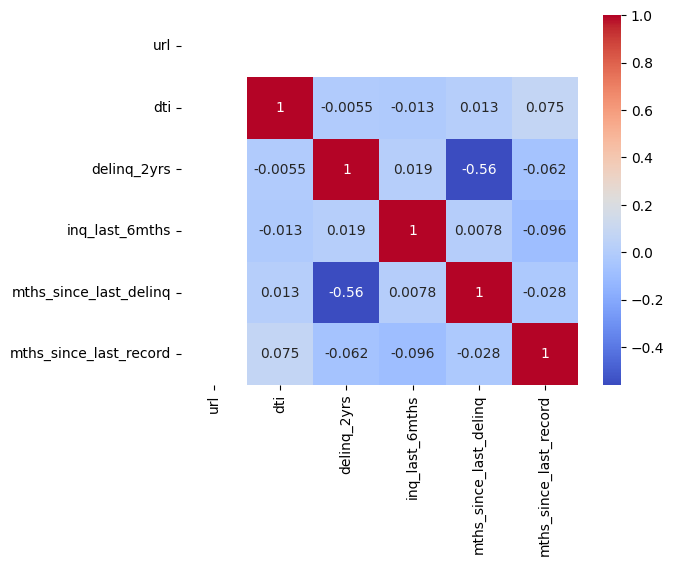

In [ ]:
correlation_matrix = df_2.select_dtypes(include='float64').corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
df_2['issue_d'] = pd.to_datetime(df_2['issue_d'], format='%b-%Y')
df_2['earliest_cr_line'] = pd.to_datetime(df_2['earliest_cr_line'], format='%b-%Y')
df_2['credit_age'] = (df_2['issue_d'] - df_2['earliest_cr_line']).dt.days / 365
df_2.head()

issue_d loan_status pymnt_plan  url desc             purpose  \
0 2013-06-01  Fully Paid          n  NaN  NaN  debt_consolidation   
1 2016-04-01     Current          n  NaN  NaN         credit_card   
2 2016-10-01  Fully Paid          n  NaN  NaN      small_business   
3 2013-09-01  Fully Paid          n  NaN  NaN  debt_consolidation   
4 2016-08-01     Current          n  NaN  NaN  debt_consolidation   

                     title zip_code addr_state    dti  delinq_2yrs  \
0           Hospital Debt     775xx         TX   3.51          0.0   
1  Credit card refinancing    782xx         TX  22.85          0.0   
2                 Business    210xx         MD   6.71          0.0   
3       Debt Consolidation    282xx         NC  15.50          0.0   
4       Debt consolidation    658xx         MO  19.88          0.0   

  earliest_cr_line  inq_last_6mths  mths_since_last_delinq  \
0       1997-11-01             0.0                    26.0   
1       2011-06-01             2.0                     NaN   
2       1996-04-01             0.0                     NaN   
3       1998-08-01             0.0                     NaN   
4       2003-12-01             0.0                    41.0   

   mths_since_last_record  credit_age  
0                     NaN   15.591781  
1                     NaN    4.838356  
2                     NaN   20.515068  
3                     NaN   15.095890  
4                     NaN   12.676712

In [ ]:
df_2 = drop_columns(df_2, ['url', 'desc', 'mths_since_last_delinq', 'mths_since_last_record', 'issue_d', 'zip_code', 'earliest_cr_line', 'addr_state'])

In [ ]:
associations = check_association(df_2.select_dtypes(include='object'))
print(associations)

{('loan_status', 'pymnt_plan'): 0.1771921967989009, ('loan_status', 'purpose'): 0.07098707734739386, ('loan_status', 'title'): 0.4466239073386647, ('pymnt_plan', 'loan_status'): 0.1771921967989009, ('pymnt_plan', 'purpose'): 0.01128596943299816, ('pymnt_plan', 'title'): 0.013726989461166919, ('purpose', 'loan_status'): 0.07098707734739386, ('purpose', 'pymnt_plan'): 0.01128596943299816, ('purpose', 'title'): 0.9804175312608342, ('title', 'loan_status'): 0.4466239073386647, ('title', 'pymnt_plan'): 0.013726989461166919, ('title', 'purpose'): 0.9804175312608342}


In [ ]:
df_2 = drop_columns(df_2, ['pymnt_plan', 'title'])

In [ ]:
df_2.dtypes

loan_status        object
purpose            object
dti               float64
delinq_2yrs       float64
inq_last_6mths    float64
credit_age        float64
dtype: object

In [ ]:
df_2['inq_last_6mths'].value_counts()

inq_last_6mths
0.0     61298
1.0     25602
2.0      8865
3.0      3097
4.0       794
5.0       271
6.0        53
7.0         6
8.0         5
10.0        5
9.0         2
Name: count, dtype: int64

In [ ]:
df_2.head()

loan_status             purpose    dti  delinq_2yrs  inq_last_6mths  \
0  Fully Paid  debt_consolidation   3.51          0.0             0.0   
1     Current         credit_card  22.85          0.0             2.0   
2  Fully Paid      small_business   6.71          0.0             0.0   
3  Fully Paid  debt_consolidation  15.50          0.0             0.0   
4     Current  debt_consolidation  19.88          0.0             0.0   

   credit_age  
0   15.591781  
1    4.838356  
2   20.515068  
3   15.095890  
4   12.676712

In [ ]:
df_2.isnull().sum()

loan_status        0
purpose            0
dti               72
delinq_2yrs        2
inq_last_6mths     2
credit_age         2
dtype: int64

#DF_3

In [ ]:
df_3.head()

open_acc  pub_rec  revol_bal  revol_util  total_acc initial_list_status  \
0      14.0      0.0       1347         8.1       22.0                   w   
1      17.0      0.0      29780        52.7       25.0                   f   
2      16.0      0.0       7425        10.3       25.0                   w   
3      10.0      0.0      24123        72.2       15.0                   f   
4      19.0      0.0      16615        49.9       48.0                   w   

   out_prncp  out_prncp_inv   total_pymnt  total_pymnt_inv  total_rec_prncp  \
0       0.00           0.00  36606.090000         36606.09         35000.00   
1   14987.66       14987.66  22115.610000         22115.61         15012.34   
2       0.00           0.00  16052.052943         16052.05         15000.00   
3       0.00           0.00  39078.323239         39078.32         24000.00   
4    2663.68        2663.68  13648.530000         13648.53         11736.32   

   total_rec_int  total_rec_late_fee  recoveries  collection_recovery_fee  
0        1606.09                 0.0         0.0                      0.0  
1        7103.27                 0.0         0.0                      0.0  
2        1052.05                 0.0         0.0                      0.0  
3       15078.32                 0.0         0.0                      0.0  
4        1912.21                 0.0         0.0                      0.0

In [ ]:
df_3.columns

Index(['open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee'],
      dtype='object')

In [ ]:
df_3.dtypes

open_acc                   float64
pub_rec                    float64
revol_bal                    int64
revol_util                 float64
total_acc                  float64
initial_list_status         object
out_prncp                  float64
out_prncp_inv              float64
total_pymnt                float64
total_pymnt_inv            float64
total_rec_prncp            float64
total_rec_int              float64
total_rec_late_fee         float64
recoveries                 float64
collection_recovery_fee    float64
dtype: object

In [ ]:
df_3.isnull().sum()

open_acc                    2
pub_rec                     2
revol_bal                   0
revol_util                 62
total_acc                   2
initial_list_status         0
out_prncp                   0
out_prncp_inv               0
total_pymnt                 0
total_pymnt_inv             0
total_rec_prncp             0
total_rec_int               0
total_rec_late_fee          0
recoveries                  0
collection_recovery_fee     0
dtype: int64

In [ ]:
df_3['initial_list_status'].value_counts()

initial_list_status
w    68116
f    31884
Name: count, dtype: int64

In [ ]:
df_3 = convert_int_to_float(df_3)
df_3.dtypes

open_acc                   float64
pub_rec                    float64
revol_bal                  float64
revol_util                 float64
total_acc                  float64
initial_list_status         object
out_prncp                  float64
out_prncp_inv              float64
total_pymnt                float64
total_pymnt_inv            float64
total_rec_prncp            float64
total_rec_int              float64
total_rec_late_fee         float64
recoveries                 float64
collection_recovery_fee    float64
dtype: object

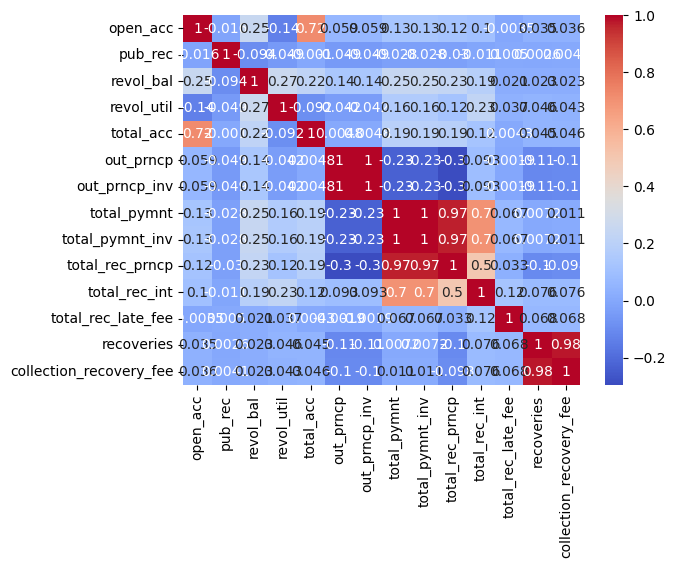

In [ ]:
correlation_matrix = df_3.select_dtypes(include='float64').corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
df_3.columns

Index(['open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee'],
      dtype='object')

In [ ]:
df_3 = drop_columns(df_3, ['out_prncp_inv', 'total_pymnt_inv', 'total_rec_prncp', 'collection_recovery_fee'])
df_3.head()

open_acc  pub_rec  revol_bal  revol_util  total_acc initial_list_status  \
0      14.0      0.0     1347.0         8.1       22.0                   w   
1      17.0      0.0    29780.0        52.7       25.0                   f   
2      16.0      0.0     7425.0        10.3       25.0                   w   
3      10.0      0.0    24123.0        72.2       15.0                   f   
4      19.0      0.0    16615.0        49.9       48.0                   w   

   out_prncp   total_pymnt  total_rec_int  total_rec_late_fee  recoveries  
0       0.00  36606.090000        1606.09                 0.0         0.0  
1   14987.66  22115.610000        7103.27                 0.0         0.0  
2       0.00  16052.052943        1052.05                 0.0         0.0  
3       0.00  39078.323239       15078.32                 0.0         0.0  
4    2663.68  13648.530000        1912.21                 0.0         0.0

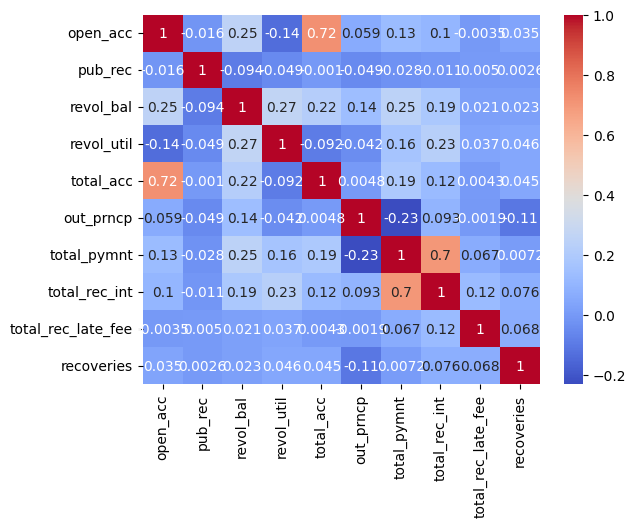

In [ ]:
correlation_matrix = df_3.select_dtypes(include='float64').corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

#DF_4

In [ ]:
df_4.head()

/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


last_pymnt_d  last_pymnt_amnt next_pymnt_d last_credit_pull_d  \
0     Dec-2013          4783.54          NaN           Jan-2014   
1     Feb-2019           648.54     Mar-2019           Feb-2019   
2     Nov-2017         10466.17          NaN           Dec-2017   
3     Sep-2018           651.03          NaN           Feb-2019   
4     Feb-2019           455.18     Mar-2019           Feb-2019   

   collections_12_mths_ex_med  mths_since_last_major_derog  policy_code  \
0                         0.0                         26.0            1   
1                         0.0                          NaN            1   
2                         0.0                          NaN            1   
3                         0.0                          NaN            1   
4                         0.0                          NaN            1   

  application_type  annual_inc_joint  dti_joint verification_status_joint  \
0       Individual               NaN        NaN                       NaN   
1       Individual               NaN        NaN                       NaN   
2       Individual               NaN        NaN                       NaN   
3       Individual               NaN        NaN                       NaN   
4       Individual               NaN        NaN                       NaN   

   acc_now_delinq  tot_coll_amt  tot_cur_bal  open_acc_6m  
0             0.0           0.0      81768.0          NaN  
1             0.0           0.0      65689.0          0.0  
2             0.0           0.0     150276.0          0.0  
3             0.0           0.0      27496.0          NaN  
4             0.0           0.0     131564.0          0.0

In [ ]:
df_4.columns

Index(['last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'open_acc_6m'],
      dtype='object')

In [ ]:
df_4.dtypes

last_pymnt_d                    object
last_pymnt_amnt                float64
next_pymnt_d                    object
last_credit_pull_d              object
collections_12_mths_ex_med     float64
mths_since_last_major_derog    float64
policy_code                      int64
application_type                object
annual_inc_joint               float64
dti_joint                      float64
verification_status_joint       object
acc_now_delinq                 float64
tot_coll_amt                   float64
tot_cur_bal                    float64
open_acc_6m                    float64
dtype: object

In [ ]:
df_4['application_type'].value_counts()

application_type
Individual    94634
Joint App      5366
Name: count, dtype: int64

In [ ]:
df_4['policy_code'].value_counts()

policy_code
1    100000
Name: count, dtype: int64

In [ ]:
df_4.isnull().sum()

last_pymnt_d                     115
last_pymnt_amnt                    0
next_pymnt_d                   57561
last_credit_pull_d                 9
collections_12_mths_ex_med         6
mths_since_last_major_derog    74272
policy_code                        0
application_type                   0
annual_inc_joint               94634
dti_joint                      94635
verification_status_joint      94855
acc_now_delinq                     2
tot_coll_amt                    3097
tot_cur_bal                     3097
open_acc_6m                    38302
dtype: int64

In [ ]:
df_4['application_type'].value_counts()

application_type
Individual    94634
Joint App      5366
Name: count, dtype: int64

In [ ]:
df_4['verification_status_joint'].value_counts()

verification_status_joint
Not Verified       2523
Source Verified    1541
Verified           1081
Name: count, dtype: int64

In [ ]:
df_4 = convert_int_to_float(df_4)
df_4.dtypes

last_pymnt_d                    object
last_pymnt_amnt                float64
next_pymnt_d                    object
last_credit_pull_d              object
collections_12_mths_ex_med     float64
mths_since_last_major_derog    float64
policy_code                    float64
application_type                object
annual_inc_joint               float64
dti_joint                      float64
verification_status_joint       object
acc_now_delinq                 float64
tot_coll_amt                   float64
tot_cur_bal                    float64
open_acc_6m                    float64
dtype: object

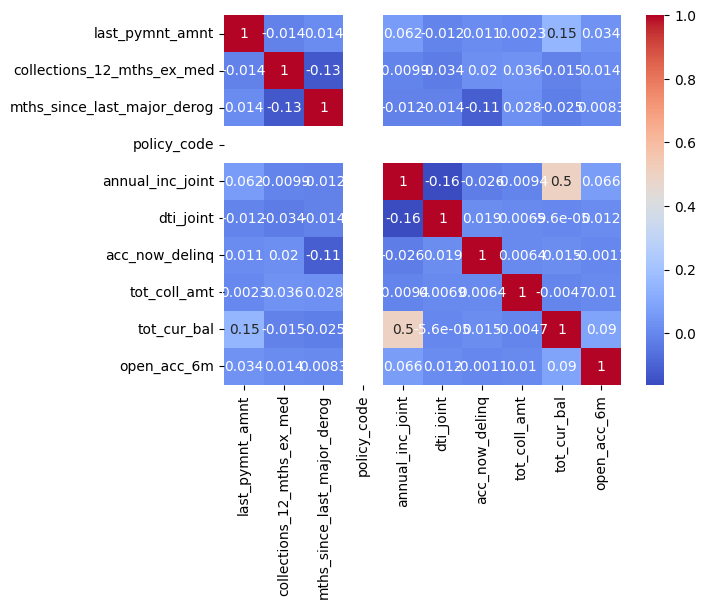

In [ ]:
correlation_matrix = df_4.select_dtypes(include='float64').corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
associations = check_association(df_4.select_dtypes(include='object'))
print(associations)

{('last_pymnt_d', 'next_pymnt_d'): 0.8078851019169819, ('last_pymnt_d', 'last_credit_pull_d'): 0.37683177569210635, ('last_pymnt_d', 'application_type'): 0.19113941454403668, ('last_pymnt_d', 'verification_status_joint'): 0.12242130849331903, ('next_pymnt_d', 'last_pymnt_d'): 0.807885101916982, ('next_pymnt_d', 'last_credit_pull_d'): 0.5822507925456614, ('next_pymnt_d', 'application_type'): 0.019715405680413318, ('next_pymnt_d', 'verification_status_joint'): 0.04130804903037308, ('last_credit_pull_d', 'last_pymnt_d'): 0.37683177569210635, ('last_credit_pull_d', 'next_pymnt_d'): 0.5822507925456614, ('last_credit_pull_d', 'application_type'): 0.12312140207708931, ('last_credit_pull_d', 'verification_status_joint'): 0.10680696729148269, ('application_type', 'last_pymnt_d'): 0.19113941454403668, ('application_type', 'next_pymnt_d'): 0.01971540568041332, ('application_type', 'last_credit_pull_d'): 0.12312140207708931, ('application_type', 'verification_status_joint'): nan, ('verification_st

<ipython-input-15-7128d6a94421>:9: RuntimeWarning: invalid value encountered in divide
  v = np.sqrt(chi2 / (n * min_dim))
<ipython-input-15-7128d6a94421>:9: RuntimeWarning: invalid value encountered in divide
  v = np.sqrt(chi2 / (n * min_dim))


In [ ]:
df_4 = drop_columns(df_4, ['next_pymnt_d', 'mths_since_last_major_derog', 'policy_code'])
df_4.head()

last_pymnt_d  last_pymnt_amnt last_credit_pull_d  \
0     Dec-2013          4783.54           Jan-2014   
1     Feb-2019           648.54           Feb-2019   
2     Nov-2017         10466.17           Dec-2017   
3     Sep-2018           651.03           Feb-2019   
4     Feb-2019           455.18           Feb-2019   

   collections_12_mths_ex_med application_type  annual_inc_joint  dti_joint  \
0                         0.0       Individual               NaN        NaN   
1                         0.0       Individual               NaN        NaN   
2                         0.0       Individual               NaN        NaN   
3                         0.0       Individual               NaN        NaN   
4                         0.0       Individual               NaN        NaN   

  verification_status_joint  acc_now_delinq  tot_coll_amt  tot_cur_bal  \
0                       NaN             0.0           0.0      81768.0   
1                       NaN             0.0           0.0      65689.0   
2                       NaN             0.0           0.0     150276.0   
3                       NaN             0.0           0.0      27496.0   
4                       NaN             0.0           0.0     131564.0   

   open_acc_6m  
0          NaN  
1          0.0  
2          0.0  
3          NaN  
4          0.0

#DF_5

In [ ]:
df_5.head()

open_act_il  open_il_12m  open_il_24m  mths_since_rcnt_il  total_bal_il  \
0          NaN          NaN          NaN                 NaN           NaN   
1          2.0          0.0          1.0                22.0       35909.0   
2          1.0          0.0          0.0                30.0        9148.0   
3          NaN          NaN          NaN                 NaN           NaN   
4          8.0          0.0          1.0                19.0      114949.0   

   il_util  open_rv_12m  open_rv_24m  max_bal_bc  all_util  total_rev_hi_lim  \
0      NaN          NaN          NaN         NaN       NaN           16700.0   
1     64.0          0.0          3.0      7525.0      58.0           56500.0   
2     58.0          1.0          4.0      3673.0      19.0           72300.0   
3      NaN          NaN          NaN         NaN       NaN           33400.0   
4    107.0          0.0          0.0      2745.0      93.0           33300.0   

   inq_fi  total_cu_tl  inq_last_12m  acc_open_past_24mths  
0     NaN          NaN           NaN                   1.0  
1     4.0          9.0           5.0                   4.0  
2     2.0          1.0           1.0                   4.0  
3     NaN          NaN           NaN                   2.0  
4     0.0          0.0           1.0                   1.0

In [ ]:
df_5.columns

Index(['open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
       'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
       'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths'],
      dtype='object')

In [ ]:
df_5.dtypes

open_act_il             float64
open_il_12m             float64
open_il_24m             float64
mths_since_rcnt_il      float64
total_bal_il            float64
il_util                 float64
open_rv_12m             float64
open_rv_24m             float64
max_bal_bc              float64
all_util                float64
total_rev_hi_lim        float64
inq_fi                  float64
total_cu_tl             float64
inq_last_12m            float64
acc_open_past_24mths    float64
dtype: object

In [ ]:
df_5.isnull().sum()

open_act_il             38302
open_il_12m             38302
open_il_24m             38302
mths_since_rcnt_il      40261
total_bal_il            38302
il_util                 47396
open_rv_12m             38302
open_rv_24m             38302
max_bal_bc              38302
all_util                38306
total_rev_hi_lim         3097
inq_fi                  38302
total_cu_tl             38302
inq_last_12m            38302
acc_open_past_24mths     2206
dtype: int64

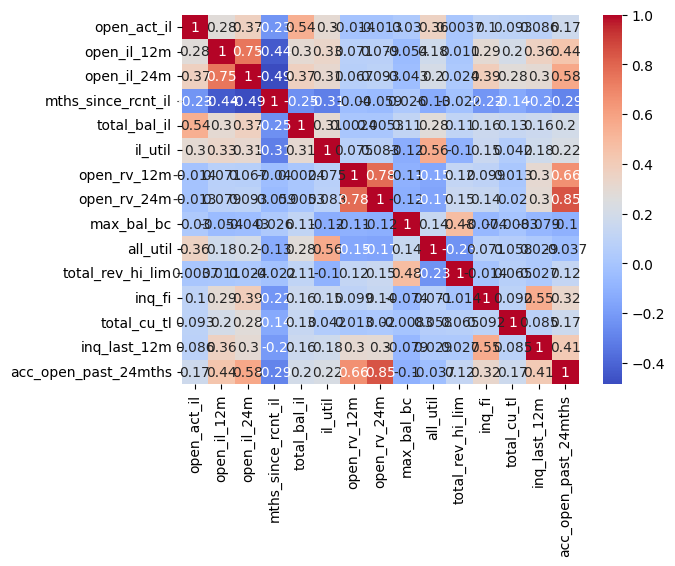

In [ ]:
correlation_matrix = df_5.select_dtypes(include='float64').corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
threshold = 0.7
high_correlation = correlation_matrix[(correlation_matrix > threshold) & (correlation_matrix != 1.0)]

high_correlation_pairs = correlation_matrix.unstack().reset_index()
high_correlation_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_correlation_pairs = high_correlation_pairs[(high_correlation_pairs['Correlation'] > threshold) & (high_correlation_pairs['Feature1'] != high_correlation_pairs['Feature2'])]

print(high_correlation_pairs)


                 Feature1              Feature2  Correlation
17            open_il_12m           open_il_24m     0.747119
31            open_il_24m           open_il_12m     0.747119
97            open_rv_12m           open_rv_24m     0.778663
111           open_rv_24m           open_rv_12m     0.778663
119           open_rv_24m  acc_open_past_24mths     0.848838
217  acc_open_past_24mths           open_rv_24m     0.848838


In [ ]:
df_5 = drop_columns(df_5, ['acc_open_past_24mths'])
df_5.head()

open_act_il  open_il_12m  open_il_24m  mths_since_rcnt_il  total_bal_il  \
0          NaN          NaN          NaN                 NaN           NaN   
1          2.0          0.0          1.0                22.0       35909.0   
2          1.0          0.0          0.0                30.0        9148.0   
3          NaN          NaN          NaN                 NaN           NaN   
4          8.0          0.0          1.0                19.0      114949.0   

   il_util  open_rv_12m  open_rv_24m  max_bal_bc  all_util  total_rev_hi_lim  \
0      NaN          NaN          NaN         NaN       NaN           16700.0   
1     64.0          0.0          3.0      7525.0      58.0           56500.0   
2     58.0          1.0          4.0      3673.0      19.0           72300.0   
3      NaN          NaN          NaN         NaN       NaN           33400.0   
4    107.0          0.0          0.0      2745.0      93.0           33300.0   

   inq_fi  total_cu_tl  inq_last_12m  
0     NaN          NaN           NaN  
1     4.0          9.0           5.0  
2     2.0          1.0           1.0  
3     NaN          NaN           NaN  
4     0.0          0.0           1.0

#Concat first 5 DFs

In [ ]:
df_concat_1 = pd.concat([df_1, df_2, df_3, df_4, df_5], axis=1)
df_concat_1.head()

loan_amnt  term  int_rate  installment grade emp_length home_ownership  \
0    35000.0  36.0     12.12      1164.51     B        < 1           RENT   
1    30000.0  60.0     10.75       648.54     B          2           RENT   
2    15000.0  36.0      7.49       466.53     A          5            OWN   
3    24000.0  60.0     21.15       651.31     E          5           RENT   
4    14400.0  36.0      8.59       455.18     A          3       MORTGAGE   

   annual_inc verification_status loan_status  ... total_bal_il  il_util  \
0     90000.0            Verified  Fully Paid  ...          NaN      NaN   
1    100000.0            Verified     Current  ...      35909.0     64.0   
2    100000.0     Source Verified  Fully Paid  ...       9148.0     58.0   
3     58000.0     Source Verified  Fully Paid  ...          NaN      NaN   
4     90000.0        Not Verified     Current  ...     114949.0    107.0   

   open_rv_12m  open_rv_24m  max_bal_bc  all_util  total_rev_hi_lim  inq_fi  \
0          NaN          NaN         NaN       NaN           16700.0     NaN   
1          0.0          3.0      7525.0      58.0           56500.0     4.0   
2          1.0          4.0      3673.0      19.0           72300.0     2.0   
3          NaN          NaN         NaN       NaN           33400.0     NaN   
4          0.0          0.0      2745.0      93.0           33300.0     0.0   

   total_cu_tl  inq_last_12m  
0          NaN           NaN  
1          9.0           5.0  
2          1.0           1.0  
3          NaN           NaN  
4          0.0           1.0  

[5 rows x 52 columns]

In [ ]:
correlation_matrix = df_concat_1.select_dtypes(include='float64').corr()

threshold = 0.7
high_correlation = correlation_matrix[(correlation_matrix > threshold) & (correlation_matrix != 1.0)]

high_correlation_pairs = correlation_matrix.unstack().reset_index()
high_correlation_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_correlation_pairs = high_correlation_pairs[(high_correlation_pairs['Correlation'] > threshold) & (high_correlation_pairs['Feature1'] != high_correlation_pairs['Feature2'])]

print(high_correlation_pairs)

              Feature1          Feature2  Correlation
3            loan_amnt       installment     0.946062
123        installment         loan_amnt     0.946062
382           open_acc         total_acc     0.718622
488          revol_bal  total_rev_hi_lim     0.794963
542          total_acc          open_acc     0.718622
1177       open_il_12m       open_il_24m     0.747119
1217       open_il_24m       open_il_12m     0.747119
1387       open_rv_12m       open_rv_24m     0.778663
1427       open_rv_24m       open_rv_12m     0.778663
1528  total_rev_hi_lim         revol_bal     0.794963


In [ ]:
df_concat_1.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'credit_age',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'total_pymnt', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'last_pymnt_d', 'last_pymnt_amnt',
       'last_credit_pull_d', 'collections_12_mths_ex_med', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m',
       'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
       'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
       'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl',
       'inq_last_12m'],
      dtype='object')

#DF_6


In [ ]:
df_6.head()

avg_cur_bal  bc_open_to_buy  bc_util  chargeoff_within_12_mths  \
0       5841.0         12053.0     10.1                       0.0   
1       3864.0         12126.0     60.6                       0.0   
2       9392.0         45813.0     12.4                       0.0   
3       2750.0          1447.0     93.0                       0.0   
4       7309.0         11121.0     46.3                       0.0   

   delinq_amnt  mo_sin_old_il_acct  mo_sin_old_rev_tl_op  \
0          0.0               169.0                 190.0   
1          0.0                49.0                  57.0   
2          0.0                96.0                 242.0   
3          0.0                90.0                 183.0   
4          0.0               144.0                 152.0   

   mo_sin_rcnt_rev_tl_op  mo_sin_rcnt_tl  mort_acc  mths_since_recent_bc  \
0                   12.0            12.0       1.0                  55.0   
1                   13.0            13.0       0.0                  25.0   
2                   10.0            10.0       1.0                  17.0   
3                   10.0            10.0       0.0                  10.0   
4                   58.0            19.0       1.0                  87.0   

   mths_since_recent_bc_dlq  mths_since_recent_inq  \
0                       NaN                    NaN   
1                       NaN                    0.0   
2                       NaN                   10.0   
3                       NaN                   10.0   
4                      41.0                    3.0   

   mths_since_recent_revol_delinq  num_accts_ever_120_pd  
0                             NaN                    1.0  
1                             NaN                    0.0  
2                             NaN                    1.0  
3                             NaN                    0.0  
4                            41.0                    0.0

In [ ]:
df_6.columns

Index(['avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
       'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd'],
      dtype='object')

In [ ]:
df_6.dtypes

avg_cur_bal                       float64
bc_open_to_buy                    float64
bc_util                           float64
chargeoff_within_12_mths          float64
delinq_amnt                       float64
mo_sin_old_il_acct                float64
mo_sin_old_rev_tl_op              float64
mo_sin_rcnt_rev_tl_op             float64
mo_sin_rcnt_tl                    float64
mort_acc                          float64
mths_since_recent_bc              float64
mths_since_recent_bc_dlq          float64
mths_since_recent_inq             float64
mths_since_recent_revol_delinq    float64
num_accts_ever_120_pd             float64
dtype: object

In [ ]:
df_6.isnull().sum()

avg_cur_bal                        3098
bc_open_to_buy                     3322
bc_util                            3379
chargeoff_within_12_mths              6
delinq_amnt                           2
mo_sin_old_il_acct                 6203
mo_sin_old_rev_tl_op               3097
mo_sin_rcnt_rev_tl_op              3097
mo_sin_rcnt_tl                     3097
mort_acc                           2206
mths_since_recent_bc               3259
mths_since_recent_bc_dlq          77066
mths_since_recent_inq             13292
mths_since_recent_revol_delinq    67297
num_accts_ever_120_pd              3097
dtype: int64

In [ ]:
correlation_matrix = df_6.select_dtypes(include='float64').corr()

threshold = 0.7
high_correlation = correlation_matrix[(correlation_matrix > threshold) & (correlation_matrix != 1.0)]

high_correlation_pairs = correlation_matrix.unstack().reset_index()
high_correlation_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_correlation_pairs = high_correlation_pairs[(high_correlation_pairs['Correlation'] > threshold) & (high_correlation_pairs['Feature1'] != high_correlation_pairs['Feature2'])]

print(high_correlation_pairs)

                           Feature1                        Feature2  \
178        mths_since_recent_bc_dlq  mths_since_recent_revol_delinq   
206  mths_since_recent_revol_delinq        mths_since_recent_bc_dlq   

     Correlation  
178     0.886379  
206     0.886379  


In [ ]:
df_6 = drop_columns(df_6, ['mths_since_recent_bc_dlq','mths_since_recent_revol_delinq'])
df_6.head()

avg_cur_bal  bc_open_to_buy  bc_util  chargeoff_within_12_mths  \
0       5841.0         12053.0     10.1                       0.0   
1       3864.0         12126.0     60.6                       0.0   
2       9392.0         45813.0     12.4                       0.0   
3       2750.0          1447.0     93.0                       0.0   
4       7309.0         11121.0     46.3                       0.0   

   delinq_amnt  mo_sin_old_il_acct  mo_sin_old_rev_tl_op  \
0          0.0               169.0                 190.0   
1          0.0                49.0                  57.0   
2          0.0                96.0                 242.0   
3          0.0                90.0                 183.0   
4          0.0               144.0                 152.0   

   mo_sin_rcnt_rev_tl_op  mo_sin_rcnt_tl  mort_acc  mths_since_recent_bc  \
0                   12.0            12.0       1.0                  55.0   
1                   13.0            13.0       0.0                  25.0   
2                   10.0            10.0       1.0                  17.0   
3                   10.0            10.0       0.0                  10.0   
4                   58.0            19.0       1.0                  87.0   

   mths_since_recent_inq  num_accts_ever_120_pd  
0                    NaN                    1.0  
1                    0.0                    0.0  
2                   10.0                    1.0  
3                   10.0                    0.0  
4                    3.0                    0.0

In [ ]:
df_6.columns

Index(['avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
       'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd'],
      dtype='object')

#df_7


In [ ]:
df_7.head()

num_actv_bc_tl  num_actv_rev_tl  num_bc_sats  num_bc_tl  num_il_tl  \
0             1.0              1.0          2.0        3.0       14.0   
1             6.0             10.0          7.0        8.0        7.0   
2             4.0              6.0          8.0       10.0        4.0   
3             4.0              7.0          5.0        7.0        5.0   
4             5.0              8.0          6.0        7.0       31.0   

   num_op_rev_tl  num_rev_accts  num_rev_tl_bal_gt_0  num_sats  \
0            5.0            7.0                  1.0      14.0   
1           15.0           18.0                 10.0      17.0   
2           13.0           17.0                  6.0      16.0   
3            8.0           10.0                  7.0      10.0   
4           11.0           16.0                  8.0      19.0   

   num_tl_120dpd_2m  num_tl_30dpd  num_tl_90g_dpd_24m  num_tl_op_past_12m  \
0               0.0           0.0                 0.0                 1.0   
1               0.0           0.0                 0.0                 0.0   
2               0.0           0.0                 0.0                 1.0   
3               0.0           0.0                 0.0                 2.0   
4               0.0           0.0                 0.0                 0.0   

   pct_tl_nvr_dlq  percent_bc_gt_75  
0            95.0               0.0  
1           100.0              57.1  
2           100.0               0.0  
3           100.0              80.0  
4            95.8              16.7

In [ ]:
df_7.columns

Index(['num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl',
       'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0',
       'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m',
       'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75'],
      dtype='object')

In [ ]:
df_7.dtypes

num_actv_bc_tl         float64
num_actv_rev_tl        float64
num_bc_sats            float64
num_bc_tl              float64
num_il_tl              float64
num_op_rev_tl          float64
num_rev_accts          float64
num_rev_tl_bal_gt_0    float64
num_sats               float64
num_tl_120dpd_2m       float64
num_tl_30dpd           float64
num_tl_90g_dpd_24m     float64
num_tl_op_past_12m     float64
pct_tl_nvr_dlq         float64
percent_bc_gt_75       float64
dtype: object

In [ ]:
df_7.isnull().sum()

num_actv_bc_tl         3097
num_actv_rev_tl        3097
num_bc_sats            2580
num_bc_tl              3097
num_il_tl              3097
num_op_rev_tl          3097
num_rev_accts          3097
num_rev_tl_bal_gt_0    3097
num_sats               2580
num_tl_120dpd_2m       6759
num_tl_30dpd           3097
num_tl_90g_dpd_24m     3097
num_tl_op_past_12m     3097
pct_tl_nvr_dlq         3102
percent_bc_gt_75       3342
dtype: int64

In [ ]:
correlation_matrix = df_7.select_dtypes(include='float64').corr()

threshold = 0.7
high_correlation = correlation_matrix[(correlation_matrix > threshold) & (correlation_matrix != 1.0)]

high_correlation_pairs = correlation_matrix.unstack().reset_index()
high_correlation_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_correlation_pairs = high_correlation_pairs[(high_correlation_pairs['Correlation'] > threshold) & (high_correlation_pairs['Feature1'] != high_correlation_pairs['Feature2'])]

print(high_correlation_pairs)

                Feature1             Feature2  Correlation
1         num_actv_bc_tl      num_actv_rev_tl     0.822809
2         num_actv_bc_tl          num_bc_sats     0.836686
7         num_actv_bc_tl  num_rev_tl_bal_gt_0     0.816183
15       num_actv_rev_tl       num_actv_bc_tl     0.822809
20       num_actv_rev_tl        num_op_rev_tl     0.797460
22       num_actv_rev_tl  num_rev_tl_bal_gt_0     0.983692
30           num_bc_sats       num_actv_bc_tl     0.836686
33           num_bc_sats            num_bc_tl     0.750150
35           num_bc_sats        num_op_rev_tl     0.765608
47             num_bc_tl          num_bc_sats     0.750150
51             num_bc_tl        num_rev_accts     0.842433
76         num_op_rev_tl      num_actv_rev_tl     0.797460
77         num_op_rev_tl          num_bc_sats     0.765608
81         num_op_rev_tl        num_rev_accts     0.796676
82         num_op_rev_tl  num_rev_tl_bal_gt_0     0.801635
83         num_op_rev_tl             num_sats     0.8378

In [ ]:
df_7 = drop_columns(df_7, ['num_rev_tl_bal_gt_0','num_actv_bc_tl','num_bc_tl'])
df_7.head()

num_actv_rev_tl  num_bc_sats  num_il_tl  num_op_rev_tl  num_rev_accts  \
0              1.0          2.0       14.0            5.0            7.0   
1             10.0          7.0        7.0           15.0           18.0   
2              6.0          8.0        4.0           13.0           17.0   
3              7.0          5.0        5.0            8.0           10.0   
4              8.0          6.0       31.0           11.0           16.0   

   num_sats  num_tl_120dpd_2m  num_tl_30dpd  num_tl_90g_dpd_24m  \
0      14.0               0.0           0.0                 0.0   
1      17.0               0.0           0.0                 0.0   
2      16.0               0.0           0.0                 0.0   
3      10.0               0.0           0.0                 0.0   
4      19.0               0.0           0.0                 0.0   

   num_tl_op_past_12m  pct_tl_nvr_dlq  percent_bc_gt_75  
0                 1.0            95.0               0.0  
1                 0.0           100.0              57.1  
2                 1.0           100.0               0.0  
3                 2.0           100.0              80.0  
4                 0.0            95.8              16.7

In [ ]:
correlation_matrix = df_7.select_dtypes(include='float64').corr()

threshold = 0.7
high_correlation = correlation_matrix[(correlation_matrix > threshold) & (correlation_matrix != 1.0)]

high_correlation_pairs = correlation_matrix.unstack().reset_index()
high_correlation_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_correlation_pairs = high_correlation_pairs[(high_correlation_pairs['Correlation'] > threshold) & (high_correlation_pairs['Feature1'] != high_correlation_pairs['Feature2'])]

print(high_correlation_pairs)

           Feature1         Feature2  Correlation
3   num_actv_rev_tl    num_op_rev_tl     0.797460
15      num_bc_sats    num_op_rev_tl     0.765608
36    num_op_rev_tl  num_actv_rev_tl     0.797460
37    num_op_rev_tl      num_bc_sats     0.765608
40    num_op_rev_tl    num_rev_accts     0.796676
41    num_op_rev_tl         num_sats     0.837820
51    num_rev_accts    num_op_rev_tl     0.796676
63         num_sats    num_op_rev_tl     0.837820


#df_8

In [ ]:
df_8.head()

/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


pub_rec_bankruptcies  tax_liens  tot_hi_cred_lim  total_bal_ex_mort  \
0                   0.0        0.0          99068.0            81768.0   
1                   0.0        0.0         113051.0            65689.0   
2                   0.0        0.0         226524.0            17874.0   
3                   0.0        0.0          38609.0            27496.0   
4                   0.0        0.0         141144.0           131564.0   

   total_bc_limit  total_il_high_credit_limit  revol_bal_joint  \
0         13400.0                     82368.0              NaN   
1         30800.0                     56551.0              NaN   
2         52300.0                     15899.0              NaN   
3         20600.0                      5209.0              NaN   
4         20700.0                    107844.0              NaN   

  sec_app_earliest_cr_line  sec_app_inq_last_6mths  sec_app_mort_acc  \
0                      NaN                     NaN               NaN   
1                      NaN                     NaN               NaN   
2                      NaN                     NaN               NaN   
3                      NaN                     NaN               NaN   
4                      NaN                     NaN               NaN   

   sec_app_open_acc  sec_app_revol_util  sec_app_open_act_il  \
0               NaN                 NaN                  NaN   
1               NaN                 NaN                  NaN   
2               NaN                 NaN                  NaN   
3               NaN                 NaN                  NaN   
4               NaN                 NaN                  NaN   

   sec_app_num_rev_accts  sec_app_chargeoff_within_12_mths  
0                    NaN                               NaN  
1                    NaN                               NaN  
2                    NaN                               NaN  
3                    NaN                               NaN  
4                    NaN                               NaN

In [ ]:
df_8.columns

Index(['pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim',
       'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',
       'revol_bal_joint', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util',
       'sec_app_open_act_il', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths'],
      dtype='object')

In [ ]:
df_8.dtypes

pub_rec_bankruptcies                float64
tax_liens                           float64
tot_hi_cred_lim                     float64
total_bal_ex_mort                   float64
total_bc_limit                      float64
total_il_high_credit_limit          float64
revol_bal_joint                     float64
sec_app_earliest_cr_line             object
sec_app_inq_last_6mths              float64
sec_app_mort_acc                    float64
sec_app_open_acc                    float64
sec_app_revol_util                  float64
sec_app_open_act_il                 float64
sec_app_num_rev_accts               float64
sec_app_chargeoff_within_12_mths    float64
dtype: object

In [ ]:
df_8.isnull().sum()

pub_rec_bankruptcies                   62
tax_liens                               4
tot_hi_cred_lim                      3097
total_bal_ex_mort                    2206
total_bc_limit                       2206
total_il_high_credit_limit           3097
revol_bal_joint                     95209
sec_app_earliest_cr_line            95209
sec_app_inq_last_6mths              95209
sec_app_mort_acc                    95209
sec_app_open_acc                    95209
sec_app_revol_util                  95296
sec_app_open_act_il                 95209
sec_app_num_rev_accts               95209
sec_app_chargeoff_within_12_mths    95209
dtype: int64

In [ ]:
df_8= drop_columns(df_8, ['sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util',
       'sec_app_open_act_il', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths'])
df_8.head()

pub_rec_bankruptcies  tax_liens  tot_hi_cred_lim  total_bal_ex_mort  \
0                   0.0        0.0          99068.0            81768.0   
1                   0.0        0.0         113051.0            65689.0   
2                   0.0        0.0         226524.0            17874.0   
3                   0.0        0.0          38609.0            27496.0   
4                   0.0        0.0         141144.0           131564.0   

   total_bc_limit  total_il_high_credit_limit  revol_bal_joint  
0         13400.0                     82368.0              NaN  
1         30800.0                     56551.0              NaN  
2         52300.0                     15899.0              NaN  
3         20600.0                      5209.0              NaN  
4         20700.0                    107844.0              NaN

In [ ]:
correlation_matrix = df_8.select_dtypes(include='float64').corr()

threshold = 0.7
high_correlation = correlation_matrix[(correlation_matrix > threshold) & (correlation_matrix != 1.0)]

high_correlation_pairs = correlation_matrix.unstack().reset_index()
high_correlation_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_correlation_pairs = high_correlation_pairs[(high_correlation_pairs['Correlation'] > threshold) & (high_correlation_pairs['Feature1'] != high_correlation_pairs['Feature2'])]
print(high_correlation_pairs)

                      Feature1                    Feature2  Correlation
26           total_bal_ex_mort  total_il_high_credit_limit     0.886577
38  total_il_high_credit_limit           total_bal_ex_mort     0.886577


In [ ]:
df_8.columns

Index(['pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim',
       'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',
       'revol_bal_joint'],
      dtype='object')

In [ ]:
df_8['pub_rec_bankruptcies'].value_counts()

pub_rec_bankruptcies
0.0    87890
1.0    11487
2.0      423
3.0      106
4.0       18
5.0        7
7.0        4
6.0        2
8.0        1
Name: count, dtype: int64

#df_9

In [ ]:
df_9.head()

/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")
/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")
/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


sec_app_collections_12_mths_ex_med  sec_app_mths_since_last_major_derog  \
0                                 NaN                                  NaN   
1                                 NaN                                  NaN   
2                                 NaN                                  NaN   
3                                 NaN                                  NaN   
4                                 NaN                                  NaN   

  hardship_flag hardship_type hardship_reason hardship_status  deferral_term  \
0             N           NaN             NaN             NaN            NaN   
1             N           NaN             NaN             NaN            NaN   
2             N           NaN             NaN             NaN            NaN   
3             N           NaN             NaN             NaN            NaN   
4             N           NaN             NaN             NaN            NaN   

   hardship_amount hardship_start_date hardship_end_date  \
0              NaN                 NaN               NaN   
1              NaN                 NaN               NaN   
2              NaN                 NaN               NaN   
3              NaN                 NaN               NaN   
4              NaN                 NaN               NaN   

  payment_plan_start_date  hardship_length  hardship_dpd hardship_loan_status  \
0                     NaN              NaN           NaN                  NaN   
1                     NaN              NaN           NaN                  NaN   
2                     NaN              NaN           NaN                  NaN   
3                     NaN              NaN           NaN                  NaN   
4                     NaN              NaN           NaN                  NaN   

   orig_projected_additional_accrued_interest  
0                                         NaN  
1                                         NaN  
2                                         NaN  
3                                         NaN  
4                                         NaN

In [ ]:
df_9.columns

Index(['sec_app_collections_12_mths_ex_med',
       'sec_app_mths_since_last_major_derog', 'hardship_flag', 'hardship_type',
       'hardship_reason', 'hardship_status', 'deferral_term',
       'hardship_amount', 'hardship_start_date', 'hardship_end_date',
       'payment_plan_start_date', 'hardship_length', 'hardship_dpd',
       'hardship_loan_status', 'orig_projected_additional_accrued_interest'],
      dtype='object')

In [ ]:
df_9.dtypes

sec_app_collections_12_mths_ex_med            float64
sec_app_mths_since_last_major_derog           float64
hardship_flag                                  object
hardship_type                                  object
hardship_reason                                object
hardship_status                                object
deferral_term                                 float64
hardship_amount                               float64
hardship_start_date                            object
hardship_end_date                              object
payment_plan_start_date                        object
hardship_length                               float64
hardship_dpd                                  float64
hardship_loan_status                           object
orig_projected_additional_accrued_interest    float64
dtype: object

In [ ]:
df_9.isnull().sum()

sec_app_collections_12_mths_ex_med            95209
sec_app_mths_since_last_major_derog           98390
hardship_flag                                     0
hardship_type                                 99525
hardship_reason                               99525
hardship_status                               99525
deferral_term                                 99525
hardship_amount                               99525
hardship_start_date                           99525
hardship_end_date                             99525
payment_plan_start_date                       99525
hardship_length                               99525
hardship_dpd                                  99525
hardship_loan_status                          99525
orig_projected_additional_accrued_interest    99615
dtype: int64

In [ ]:
df_9['hardship_flag'].value_counts()

hardship_flag
N    99959
Y       41
Name: count, dtype: int64

In [ ]:
df_9=df_9['hardship_flag']

In [ ]:
df_9

0        N
1        N
2        N
3        N
4        N
        ..
99995    N
99996    N
99997    N
99998    N
99999    N
Name: hardship_flag, Length: 100000, dtype: object

In [ ]:
df_9.value_counts()

hardship_flag
N    99959
Y       41
Name: count, dtype: int64

#df_10

In [ ]:
df_10.head()

/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")
/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


hardship_payoff_balance_amount  hardship_last_payment_amount  \
0                             NaN                           NaN   
1                             NaN                           NaN   
2                             NaN                           NaN   
3                             NaN                           NaN   
4                             NaN                           NaN   

  disbursement_method debt_settlement_flag debt_settlement_flag_date  \
0                Cash                    N                       NaN   
1                Cash                    N                       NaN   
2                Cash                    N                       NaN   
3                Cash                    N                       NaN   
4                Cash                    N                       NaN   

  settlement_status settlement_date  settlement_amount  settlement_percentage  \
0               NaN             NaN                NaN                    NaN   
1               NaN             NaN                NaN                    NaN   
2               NaN             NaN                NaN                    NaN   
3               NaN             NaN                NaN                    NaN   
4               NaN             NaN                NaN                    NaN   

   settlement_term  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN

In [ ]:
df_10.columns

Index(['hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object')

In [ ]:
df_10.dtypes

hardship_payoff_balance_amount    float64
hardship_last_payment_amount      float64
disbursement_method                object
debt_settlement_flag               object
debt_settlement_flag_date          object
settlement_status                  object
settlement_date                    object
settlement_amount                 float64
settlement_percentage             float64
settlement_term                   float64
dtype: object

In [ ]:
df_10.isnull().sum()

hardship_payoff_balance_amount    99525
hardship_last_payment_amount      99525
disbursement_method                   0
debt_settlement_flag                  0
debt_settlement_flag_date         98537
settlement_status                 98537
settlement_date                   98537
settlement_amount                 98537
settlement_percentage             98537
settlement_term                   98537
dtype: int64

In [ ]:
df_10['disbursement_method'].value_counts()

disbursement_method
Cash         96538
DirectPay     3462
Name: count, dtype: int64

In [ ]:
df_10['debt_settlement_flag'].value_counts()

debt_settlement_flag
N    98537
Y     1463
Name: count, dtype: int64

In [ ]:
df_10=df_10[['disbursement_method','debt_settlement_flag']]

In [ ]:
df_10

disbursement_method debt_settlement_flag
0                    Cash                    N
1                    Cash                    N
2                    Cash                    N
3                    Cash                    N
4                    Cash                    N
...                   ...                  ...
99995                Cash                    N
99996                Cash                    N
99997           DirectPay                    N
99998                Cash                    N
99999                Cash                    N

[100000 rows x 2 columns]

In [ ]:
df_10['disbursement_method'].value_counts()

disbursement_method
Cash         96538
DirectPay     3462
Name: count, dtype: int64

In [ ]:
df_10['debt_settlement_flag'].value_counts()

debt_settlement_flag
N    98537
Y     1463
Name: count, dtype: int64

#combine


In [ ]:
df_concat_2 = pd.concat([df_6, df_7, df_8, df_9, df_10], axis=1)
df_concat_2.head()

avg_cur_bal  bc_open_to_buy  bc_util  chargeoff_within_12_mths  \
0       5841.0         12053.0     10.1                       0.0   
1       3864.0         12126.0     60.6                       0.0   
2       9392.0         45813.0     12.4                       0.0   
3       2750.0          1447.0     93.0                       0.0   
4       7309.0         11121.0     46.3                       0.0   

   delinq_amnt  mo_sin_old_il_acct  mo_sin_old_rev_tl_op  \
0          0.0               169.0                 190.0   
1          0.0                49.0                  57.0   
2          0.0                96.0                 242.0   
3          0.0                90.0                 183.0   
4          0.0               144.0                 152.0   

   mo_sin_rcnt_rev_tl_op  mo_sin_rcnt_tl  mort_acc  ...  pub_rec_bankruptcies  \
0                   12.0            12.0       1.0  ...                   0.0   
1                   13.0            13.0       0.0  ...                   0.0   
2                   10.0            10.0       1.0  ...                   0.0   
3                   10.0            10.0       0.0  ...                   0.0   
4                   58.0            19.0       1.0  ...                   0.0   

   tax_liens  tot_hi_cred_lim  total_bal_ex_mort  total_bc_limit  \
0        0.0          99068.0            81768.0         13400.0   
1        0.0         113051.0            65689.0         30800.0   
2        0.0         226524.0            17874.0         52300.0   
3        0.0          38609.0            27496.0         20600.0   
4        0.0         141144.0           131564.0         20700.0   

   total_il_high_credit_limit  revol_bal_joint  hardship_flag  \
0                     82368.0              NaN              N   
1                     56551.0              NaN              N   
2                     15899.0              NaN              N   
3                      5209.0              NaN              N   
4                    107844.0              NaN              N   

   disbursement_method  debt_settlement_flag  
0                 Cash                     N  
1                 Cash                     N  
2                 Cash                     N  
3                 Cash                     N  
4                 Cash                     N  

[5 rows x 35 columns]

In [ ]:
correlation_matrix = df_concat_2.select_dtypes(include='float64').corr()

threshold = 0.7
high_correlation = correlation_matrix[(correlation_matrix > threshold) & (correlation_matrix != 1.0)]

high_correlation_pairs = correlation_matrix.unstack().reset_index()
high_correlation_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_correlation_pairs = high_correlation_pairs[(high_correlation_pairs['Correlation'] > threshold) & (high_correlation_pairs['Feature1'] != high_correlation_pairs['Feature2'])]
print(high_correlation_pairs)

                       Feature1                    Feature2  Correlation
27                  avg_cur_bal             tot_hi_cred_lim     0.797656
61               bc_open_to_buy              total_bc_limit     0.846093
88                      bc_util            percent_bc_gt_75     0.845915
432             num_actv_rev_tl               num_op_rev_tl     0.797460
464                 num_bc_sats               num_op_rev_tl     0.765608
525               num_op_rev_tl             num_actv_rev_tl     0.797460
526               num_op_rev_tl                 num_bc_sats     0.765608
529               num_op_rev_tl               num_rev_accts     0.796676
530               num_op_rev_tl                    num_sats     0.837820
560               num_rev_accts               num_op_rev_tl     0.796676
592                    num_sats               num_op_rev_tl     0.837820
770            percent_bc_gt_75                     bc_util     0.845915
864             tot_hi_cred_lim                 avg

In [ ]:
df_concat_2.columns

Index(['avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
       'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_rev_tl', 'num_bc_sats', 'num_il_tl',
       'num_op_rev_tl', 'num_rev_accts', 'num_sats', 'num_tl_120dpd_2m',
       'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
       'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies',
       'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'revol_bal_joint', 'hardship_flag',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')

#Main df

In [ ]:
main_df = pd.concat([df_concat_1,df_concat_2], axis=1)
main_df.head()

loan_amnt  term  int_rate  installment grade emp_length home_ownership  \
0    35000.0  36.0     12.12      1164.51     B        < 1           RENT   
1    30000.0  60.0     10.75       648.54     B          2           RENT   
2    15000.0  36.0      7.49       466.53     A          5            OWN   
3    24000.0  60.0     21.15       651.31     E          5           RENT   
4    14400.0  36.0      8.59       455.18     A          3       MORTGAGE   

   annual_inc verification_status loan_status  ... pub_rec_bankruptcies  \
0     90000.0            Verified  Fully Paid  ...                  0.0   
1    100000.0            Verified     Current  ...                  0.0   
2    100000.0     Source Verified  Fully Paid  ...                  0.0   
3     58000.0     Source Verified  Fully Paid  ...                  0.0   
4     90000.0        Not Verified     Current  ...                  0.0   

   tax_liens  tot_hi_cred_lim  total_bal_ex_mort  total_bc_limit  \
0        0.0          99068.0            81768.0         13400.0   
1        0.0         113051.0            65689.0         30800.0   
2        0.0         226524.0            17874.0         52300.0   
3        0.0          38609.0            27496.0         20600.0   
4        0.0         141144.0           131564.0         20700.0   

   total_il_high_credit_limit  revol_bal_joint  hardship_flag  \
0                     82368.0              NaN              N   
1                     56551.0              NaN              N   
2                     15899.0              NaN              N   
3                      5209.0              NaN              N   
4                    107844.0              NaN              N   

   disbursement_method  debt_settlement_flag  
0                 Cash                     N  
1                 Cash                     N  
2                 Cash                     N  
3                 Cash                     N  
4                 Cash                     N  

[5 rows x 87 columns]

In [ ]:
main_df.isnull().sum()

loan_amnt                         0
term                              0
int_rate                          0
installment                       0
grade                             0
                              ...  
total_il_high_credit_limit     3097
revol_bal_joint               95209
hardship_flag                     0
disbursement_method               0
debt_settlement_flag              0
Length: 87, dtype: int64

In [ ]:
correlation_matrix = main_df.select_dtypes(include='float64').corr()

threshold = 0.7
high_correlation = correlation_matrix[(correlation_matrix > threshold) & (correlation_matrix != 1.0)]

high_correlation_pairs = correlation_matrix.unstack().reset_index()
high_correlation_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_correlation_pairs = high_correlation_pairs[(high_correlation_pairs['Correlation'] > threshold) & (high_correlation_pairs['Feature1'] != high_correlation_pairs['Feature2'])]
print(high_correlation_pairs)

                        Feature1                    Feature2  Correlation
3                      loan_amnt                 installment     0.946062
219                  installment                   loan_amnt     0.946062
631                   credit_age        mo_sin_old_rev_tl_op     0.913887
670                     open_acc                   total_acc     0.718622
714                     open_acc               num_op_rev_tl     0.838542
716                     open_acc                    num_sats     0.998945
840                    revol_bal            total_rev_hi_lim     0.794963
919                   revol_util                     bc_util     0.870574
941                   revol_util            percent_bc_gt_75     0.740772
958                    total_acc                    open_acc     0.718622
1007                   total_acc               num_rev_accts     0.763656
1008                   total_acc                    num_sats     0.716808
1740              acc_now_delinq      

In [ ]:
main_df['recoveries'].value_counts()

recoveries
0.00        92215
50.00          45
100.00         31
150.00         27
25.00          18
            ...  
1137.84         1
10403.15        1
1544.68         1
953.11          1
982.00          1
Name: count, Length: 7313, dtype: int64

#EDA

In [ ]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 87 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   100000 non-null  float64
 1   term                        100000 non-null  float64
 2   int_rate                    100000 non-null  float64
 3   installment                 100000 non-null  float64
 4   grade                       100000 non-null  object 
 5   emp_length                  93438 non-null   object 
 6   home_ownership              100000 non-null  object 
 7   annual_inc                  100000 non-null  float64
 8   verification_status         100000 non-null  object 
 9   loan_status                 100000 non-null  object 
 10  purpose                     100000 non-null  object 
 11  dti                         99928 non-null   float64
 12  delinq_2yrs                 99998 non-null   float64
 13  inq_last_6mths 

In [ ]:
main_df.describe()

loan_amnt           term       int_rate    installment  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean    15031.287250      42.853680      13.110404     445.918598   
std      9215.551155      10.840506       4.846582     268.321165   
min       800.000000      36.000000       5.310000      21.250000   
25%      8000.000000      36.000000       9.490000     250.997500   
50%     12800.000000      36.000000      12.620000     377.890000   
75%     20000.000000      60.000000      15.990000     594.620000   
max     40000.000000      60.000000      30.990000    1715.420000   

         annual_inc           dti   delinq_2yrs  inq_last_6mths    credit_age  \
count  1.000000e+05  99928.000000  99998.000000    99998.000000  99998.000000   
mean   7.765991e+04     18.825358      0.303146        0.576232     16.396703   
std    7.156694e+04     13.377725      0.847541        0.885419      7.664215   
min    0.000000e+00     -1.000000      0.000000        0.000000      1.000000   
25%    4.600000e+04     11.880000      0.000000        0.000000     11.260274   
50%    6.500000e+04     17.890000      0.000000        0.000000     14.843836   
75%    9.300000e+04     24.560000      0.000000        1.000000     20.265753   
max    9.522972e+06    999.000000     21.000000       10.000000     69.715068   

           open_acc  ...  num_tl_op_past_12m  pct_tl_nvr_dlq  \
count  99998.000000  ...        96903.000000    96898.000000   
mean      11.612132  ...            2.074776       94.121045   
std        5.642611  ...            1.835954        9.044520   
min        0.000000  ...            0.000000        7.100000   
25%        8.000000  ...            1.000000       91.300000   
50%       11.000000  ...            2.000000      100.000000   
75%       14.000000  ...            3.000000      100.000000   
max       90.000000  ...           26.000000      100.000000   

       percent_bc_gt_75  pub_rec_bankruptcies     tax_liens  tot_hi_cred_lim  \
count      96658.000000          99938.000000  99996.000000     9.690300e+04   
mean          42.454695              0.128139      0.047152     1.769534e+05   
std           36.196862              0.364629      0.375571     1.770158e+05   
min            0.000000              0.000000      0.000000     0.000000e+00   
25%            0.000000              0.000000      0.000000     5.081600e+04   
50%           37.500000              0.000000      0.000000     1.137900e+05   
75%           71.400000              0.000000      0.000000     2.566160e+05   
max          100.000000              8.000000     22.000000     4.317023e+06   

       total_bal_ex_mort  total_bc_limit  total_il_high_credit_limit  \
count       9.779400e+04    97794.000000                9.690300e+04   
mean        5.077966e+04    23213.349592                4.346859e+04   
std         4.865343e+04    23015.798701                4.472882e+04   
min         0.000000e+00        0.000000                0.000000e+00   
25%         2.089525e+04     8200.000000                1.500000e+04   
50%         3.786500e+04    16300.000000                3.258100e+04   
75%         6.427350e+04    30400.000000                5.853850e+04   
max         1.550157e+06   571500.000000                1.548183e+06   

       revol_bal_joint  
count      4791.000000  
mean      34205.647881  
std       28120.779303  
min           0.000000  
25%       15303.000000  
50%       26702.000000  
75%       44853.500000  
max      279083.000000  

[8 rows x 73 columns]

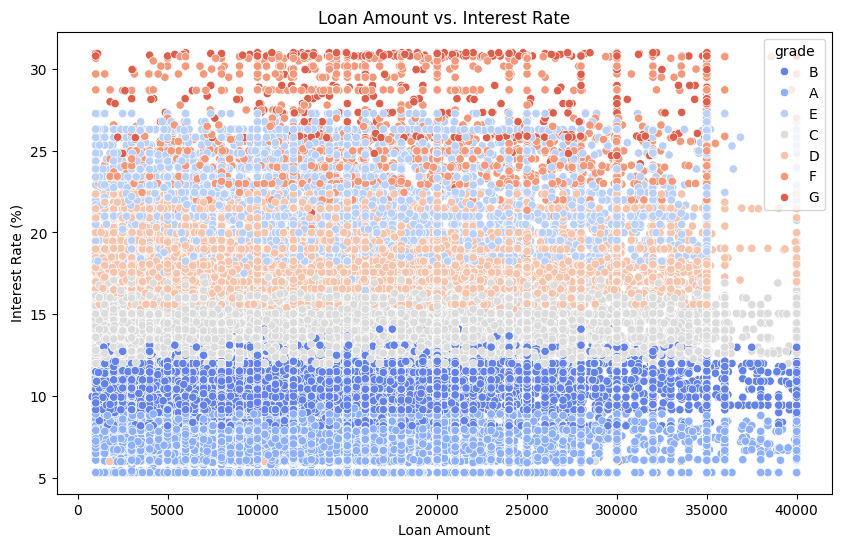

In [ ]:
# Scatter Plot: Loan Amount vs Interest Rate
plt.figure(figsize=(10, 6))
sns.scatterplot(data=main_df, x='loan_amnt', y='int_rate', hue='grade', palette='coolwarm')
plt.title('Loan Amount vs. Interest Rate')
plt.xlabel('Loan Amount')
plt.ylabel('Interest Rate (%)')
plt.show()

<ipython-input-155-656a69fcaad0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=main_df, x='purpose', order=main_df['purpose'].value_counts().index, palette='Set2')


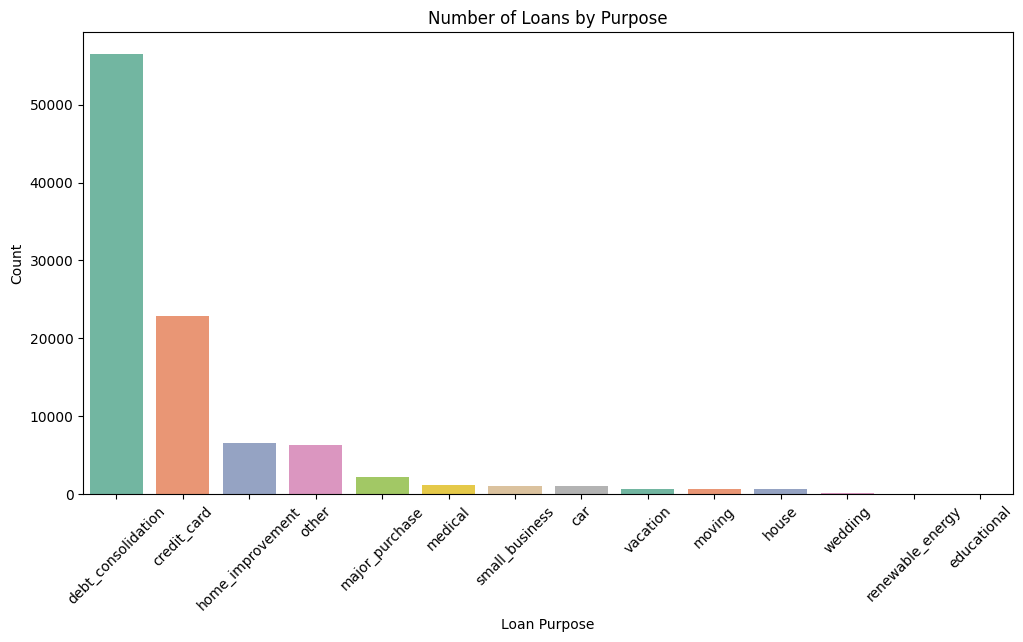

In [ ]:
# Loan Purpose Count Plot
plt.figure(figsize=(12, 6))
sns.countplot(data=main_df, x='purpose', order=main_df['purpose'].value_counts().index, palette='Set2')
plt.title('Number of Loans by Purpose')
plt.xticks(rotation=45)
plt.xlabel('Loan Purpose')
plt.ylabel('Count')
plt.show()

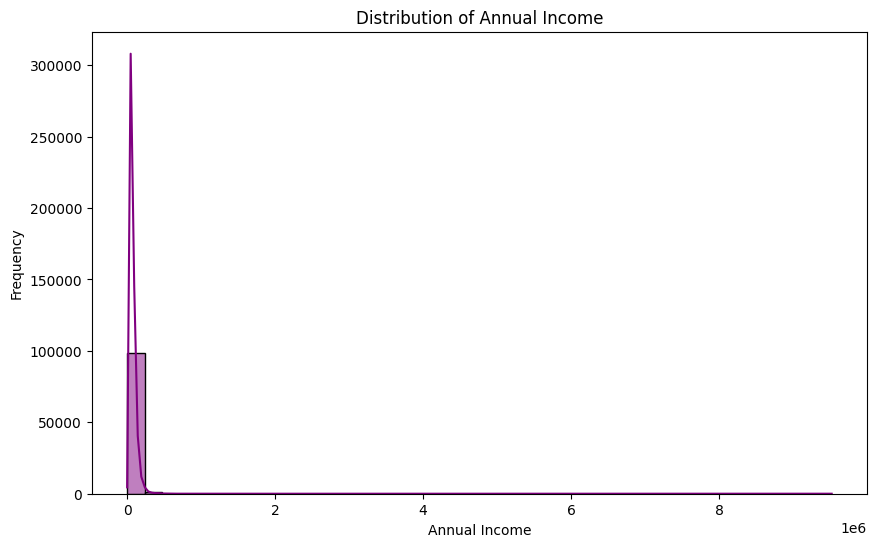

In [ ]:
# Annual Income Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=main_df, x='annual_inc', bins=40, kde=True, color='purple')
plt.title('Distribution of Annual Income')
plt.xlabel('Annual Income')
plt.ylabel('Frequency')
plt.show()

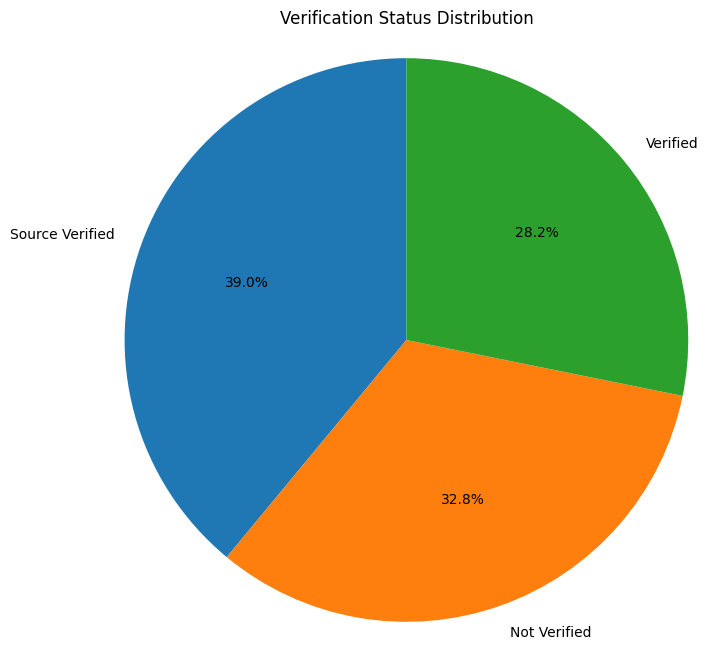

In [ ]:
verification_status_counts = main_df['verification_status'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(verification_status_counts, labels=verification_status_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Verification Status Distribution')
plt.axis('equal')
plt.show()

<ipython-input-158-f9c45f2a3581>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=main_df, x='loan_status', y='credit_age', palette='coolwarm')


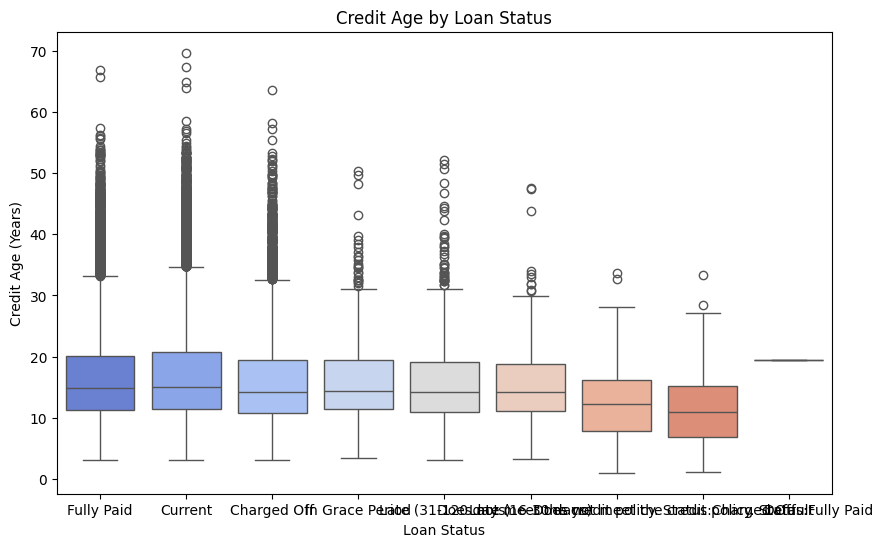

In [ ]:
# Box Plot of Credit Age by Loan Status
plt.figure(figsize=(10, 6))
sns.boxplot(data=main_df, x='loan_status', y='credit_age', palette='coolwarm')
plt.title('Credit Age by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Credit Age (Years)')

plt.show()

<ipython-input-162-c892f96f1404>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=main_df, x='revol_util', y='loan_amnt', cmap='Reds', shade=True)


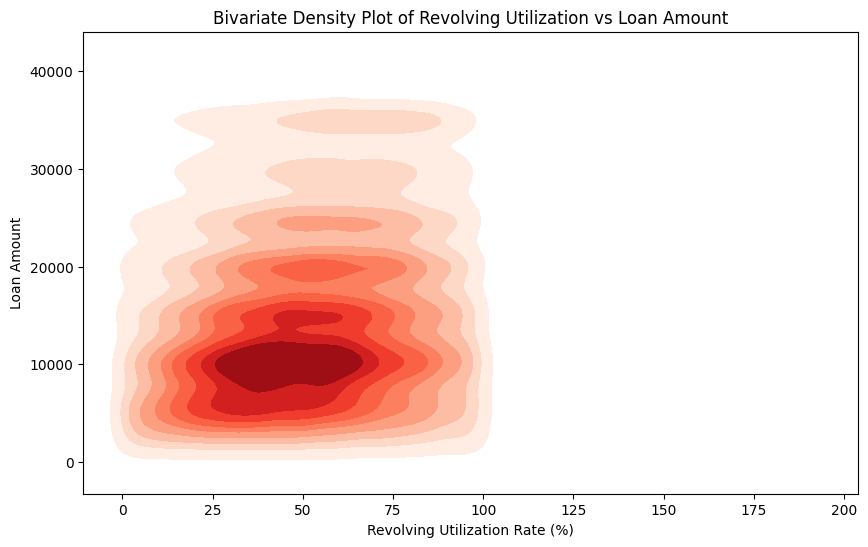

In [ ]:
# Bivariate Density Plot (Revolving Utilization vs Loan Amount)
plt.figure(figsize=(10, 6))
sns.kdeplot(data=main_df, x='revol_util', y='loan_amnt', cmap='Reds', shade=True)
plt.title('Bivariate Density Plot of Revolving Utilization vs Loan Amount')
plt.xlabel('Revolving Utilization Rate (%)')
plt.ylabel('Loan Amount')
plt.show()

In [ ]:
grade_trends = main_df.groupby('grade')['loan_amnt'].mean()

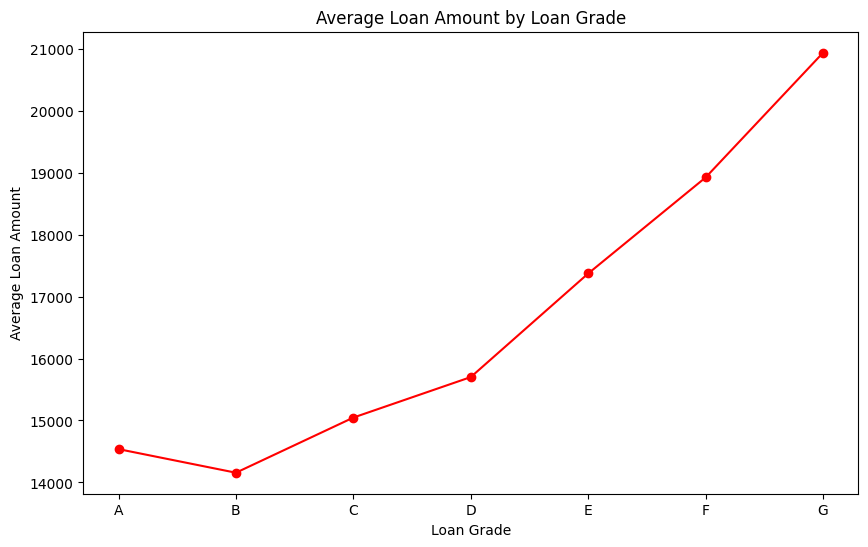

In [ ]:
# Average loan amount by loan grade
plt.figure(figsize=(10, 6))
grade_trends.plot(kind='line', marker='o', color='red')
plt.title('Average Loan Amount by Loan Grade')
plt.xlabel('Loan Grade')
plt.ylabel('Average Loan Amount')
plt.show()

#Feature Engineering

In [ ]:
main_df.isnull().sum()

loan_amnt                         0
term                              0
int_rate                          0
installment                       0
grade                             0
                              ...  
total_il_high_credit_limit     3097
revol_bal_joint               95209
hardship_flag                     0
disbursement_method               0
debt_settlement_flag              0
Length: 87, dtype: int64

In [ ]:
try_df = main_df.copy()

In [ ]:
main_df['dti_combined'] = main_df.apply(lambda x: x['dti_joint'] if x['application_type'] == 'Joint' else x['dti'], axis=1)
main_df['annual_inc_combined'] = main_df.apply(lambda x: x['annual_inc_joint'] if x['application_type'] == 'Joint' else x['annual_inc'], axis=1)
main_df['verification_status_combined'] = main_df.apply(lambda x: x['verification_status_joint'] if x['application_type'] == 'Joint' else x['verification_status'], axis=1)
main_df['revol_bal_combined'] = main_df.apply(lambda x: x['revol_bal_joint'] if x['application_type'] == 'Joint' else x['revol_bal'], axis=1)

In [ ]:
main_df = main_df.drop(columns=['dti', 'dti_joint', 'annual_inc', 'annual_inc_joint', 'verification_status', 'verification_status_joint', 'revol_bal', 'revol_bal_joint'])

In [ ]:
main_df['inq_rate'] = main_df.apply(lambda x: x['inq_last_6mths'] / (x['inq_last_12m'] - x['inq_last_6mths'])
                                    if (x['inq_last_12m'] - x['inq_last_6mths']) > 0 else 0, axis=1)

In [ ]:
main_df['il_rate'] = main_df.apply(lambda x: x['open_il_12m'] / (x['open_il_24m'] - x['open_il_12m'])
                                    if (x['open_il_24m'] - x['open_il_12m']) > 0 else 0, axis=1)

In [ ]:
main_df['rv_rate'] = main_df.apply(lambda x: x['open_rv_12m'] / (x['open_rv_24m'] - x['open_rv_12m'])
                                    if (x['open_rv_24m'] - x['open_rv_12m']) > 0 else 0, axis=1)

In [ ]:
main_df['acc_ratio'] = main_df['open_acc'] / main_df['total_acc']

In [ ]:
main_df = main_df.drop(columns=['inq_last_6mths', 'inq_last_12m', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m'])

In [ ]:
main_df.shape[1]

81

In [ ]:
main_df['delinquency_flag'] = main_df.apply(lambda x: 1 if (x['acc_now_delinq'] > 0 or x['delinq_2yrs'] >= 2) else 0, axis=1)

In [ ]:
main_df['delinquency_flag'].value_counts()

delinquency_flag
0    93673
1     6327
Name: count, dtype: int64

In [ ]:
main_df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length',
       'home_ownership', 'loan_status', 'purpose', 'delinq_2yrs', 'credit_age',
       'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'initial_list_status',
       'out_prncp', 'total_pymnt', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'max_bal_bc',
       'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_rev_tl',
       'num_bc_sats', 'n

In [ ]:
main_df[['mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mths_since_recent_bc']].value_counts()

mo_sin_old_il_acct  mo_sin_old_rev_tl_op  mo_sin_rcnt_rev_tl_op  mo_sin_rcnt_tl  mths_since_recent_bc
148.0               154.0                 3.0                    3.0             3.0                     4
111.0               123.0                 3.0                    3.0             3.0                     4
129.0               163.0                 3.0                    3.0             3.0                     3
140.0               220.0                 1.0                    1.0             1.0                     3
123.0               118.0                 2.0                    2.0             2.0                     3
                                                                                                        ..
112.0               166.0                 1.0                    1.0             1.0                     1
                    165.0                 45.0                   23.0            45.0                    1
                                          16.0                   8.0             33.0                    1
                    163.0                 66.0                   14.0            157.0                   1
                    169.0                 6.0                    6.0             6.0                     1
Name: count, Length: 91855, dtype: int64

In [ ]:
main_df['il_ratio'] = main_df.apply(lambda x: x['open_act_il'] / x['num_il_tl']
                                      if x['num_il_tl'] > 0 else 0, axis=1)

In [ ]:
main_df['mths_since_op'] = main_df.apply(lambda x: min(x['mo_sin_old_il_acct'],
                                                      x['mo_sin_old_rev_tl_op'],
                                                      x['mo_sin_rcnt_rev_tl_op'],
                                                      x['mo_sin_rcnt_tl'],
                                                      x['mths_since_recent_bc'],x['mths_since_rcnt_il']), axis=1)


In [ ]:
main_df['mths_since_op'].value_counts()

mths_since_op
2.0      10197
3.0       9775
4.0       8810
1.0       7841
5.0       7563
         ...  
123.0        1
100.0        1
104.0        1
114.0        1
197.0        1
Name: count, Length: 125, dtype: int64

In [ ]:
main_df['total_credit_exposure'] = main_df['num_il_tl'] + main_df['num_op_rev_tl']


In [ ]:
main_df['satisfactory_ratio'] = main_df.apply(lambda x: x['num_sats'] / x['total_acc'] if x['total_acc'] > 0 else 0, axis=1)


In [ ]:
main_df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length',
       'home_ownership', 'loan_status', 'purpose', 'delinq_2yrs', 'credit_age',
       'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'initial_list_status',
       'out_prncp', 'total_pymnt', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'max_bal_bc',
       'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_rev_tl',
       'num_bc_sats', 'n

In [ ]:
# List of columns to drop
columns_to_drop = [
    'last_pymnt_d', 'pub_rec_bankruptcies', 'tax_liens',
    'initial_list_status', 'out_prncp',
    'total_rec_int', 'total_rec_late_fee',
    'last_pymnt_amnt', 'last_credit_pull_d', 'revol_bal_combined',
    'total_bal_ex_mort', 'total_bal_il', 'max_bal_bc',
    'tot_cur_bal', 'avg_cur_bal', 'mths_since_recent_inq',
    'total_cu_tl', 'open_act_il', 'num_il_tl', 'delinq_amnt',
    'num_bc_sats', 'num_actv_rev_tl', 'total_acc',
    'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
    'disbursement_method', 'total_il_high_credit_limit',
    'inq_fi', 'acc_now_delinq', 'delinq_2yrs',
    'revol_util', 'bc_util', 'il_util',
    'total_rev_hi_lim', 'total_bc_limit',
    'total_il_high_credit_limit', 'mo_sin_old_il_acct',
    'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
    'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'num_op_rev_tl',
    'num_il_tl', 'num_sats', 'total_acc',
    'num_tl_120dpd_2m', 'num_tl_90g_dpd_24m',
    'num_tl_op_past_12m','mths_since_rcnt_il'
]

main_df.drop(columns=columns_to_drop, inplace=True)


In [ ]:
main_df.rename(columns={
    'all_util': 'credit_utilization',
    'tot_hi_cred_lim': 'high_credit_limit'
}, inplace=True)


#Missing Value

In [ ]:
missing_values = main_df.isnull().sum()
missing_columns = missing_values[missing_values > 0]
print(missing_columns)

emp_length                     6562
credit_age                        2
open_acc                          2
pub_rec                           2
collections_12_mths_ex_med        6
tot_coll_amt                   3097
open_acc_6m                   38302
credit_utilization            38306
bc_open_to_buy                 3322
chargeoff_within_12_mths          6
mort_acc                       2206
num_accts_ever_120_pd          3097
num_tl_30dpd                   3097
pct_tl_nvr_dlq                 3102
percent_bc_gt_75               3342
high_credit_limit              3097
dti_combined                     72
acc_ratio                         2
il_ratio                      34057
mths_since_op                  6203
total_credit_exposure          3097
satisfactory_ratio             2578
dtype: int64


In [ ]:
main_df['emp_length'] = np.where(main_df['emp_length'] == '< 1', 'Less than 1',
                          np.where(main_df['emp_length'].isin(['1','2', '3', '4', '5']), '1 to 5',
                          np.where(main_df['emp_length'].isin(['6', '7', '8', '9', '10']), '6 to 10',
                          np.where(main_df['emp_length'] == '10+', 'More than 10', main_df['emp_length']))))

In [ ]:
main_df['emp_length']

0         Less than 1
1              1 to 5
2              1 to 5
3              1 to 5
4              1 to 5
             ...     
99995          1 to 5
99996         6 to 10
99997          1 to 5
99998    More than 10
99999    More than 10
Name: emp_length, Length: 100000, dtype: object

In [ ]:
main_df['emp_length'] = main_df['emp_length'].astype('category')

In [ ]:
knn_imputer = KNNImputer(n_neighbors=5)

main_df['emp_length'], uniques = pd.factorize(main_df['emp_length'])
emp_length_reshaped = main_df[['emp_length']].values
main_df['emp_length'] = knn_imputer.fit_transform(emp_length_reshaped)
main_df['emp_length'] = uniques[main_df['emp_length'].astype(int)]

In [ ]:
main_df['emp_length']

0         Less than 1
1              1 to 5
2              1 to 5
3              1 to 5
4              1 to 5
             ...     
99995          1 to 5
99996         6 to 10
99997          1 to 5
99998    More than 10
99999    More than 10
Name: emp_length, Length: 100000, dtype: category
Categories (4, object): ['1 to 5', '6 to 10', 'Less than 1', 'More than 10']

In [ ]:
float_cols = main_df.select_dtypes(include=['float64']).columns
int_cols = main_df.select_dtypes(include=['int64']).columns
num_cols = float_cols.union(int_cols)
print("Columns selected for imputation:", num_cols)

knn_imputer = KNNImputer(n_neighbors=5)

main_df[num_cols] = knn_imputer.fit_transform(main_df[num_cols])

Columns selected for imputation: Index(['acc_ratio', 'annual_inc_combined', 'bc_open_to_buy',
       'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'credit_age',
       'credit_utilization', 'delinquency_flag', 'dti_combined',
       'high_credit_limit', 'il_rate', 'il_ratio', 'inq_rate', 'installment',
       'int_rate', 'loan_amnt', 'mort_acc', 'mths_since_op',
       'num_accts_ever_120_pd', 'num_tl_30dpd', 'open_acc', 'open_acc_6m',
       'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec', 'recoveries',
       'rv_rate', 'satisfactory_ratio', 'term', 'tot_coll_amt',
       'total_credit_exposure', 'total_pymnt'],
      dtype='object')


In [ ]:
main_df.isnull().sum()

loan_amnt                       0
term                            0
int_rate                        0
installment                     0
grade                           0
emp_length                      0
home_ownership                  0
loan_status                     0
purpose                         0
credit_age                      0
open_acc                        0
pub_rec                         0
total_pymnt                     0
recoveries                      0
collections_12_mths_ex_med      0
application_type                0
tot_coll_amt                    0
open_acc_6m                     0
credit_utilization              0
bc_open_to_buy                  0
chargeoff_within_12_mths        0
mort_acc                        0
num_accts_ever_120_pd           0
num_tl_30dpd                    0
pct_tl_nvr_dlq                  0
percent_bc_gt_75                0
high_credit_limit               0
hardship_flag                   0
debt_settlement_flag            0
dti_combined                    0
annual_inc_combined             0
verification_status_combined    0
inq_rate                        0
il_rate                         0
rv_rate                         0
acc_ratio                       0
delinquency_flag                0
il_ratio                        0
mths_since_op                   0
total_credit_exposure           0
satisfactory_ratio              0
dtype: int64

In [ ]:
columns_to_round = [
    'annual_inc_combined', 'bc_open_to_buy', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med',
    'credit_utilization', 'delinquency_flag', 'high_credit_limit', 'loan_amnt', 'mths_since_op', 'mort_acc',
    'num_accts_ever_120_pd', 'num_tl_30dpd', 'open_acc', 'open_acc_6m', 'pub_rec',
    'term', 'tot_coll_amt', 'total_credit_exposure'
]

main_df[columns_to_round] = main_df[columns_to_round].round(decimals=0)
print(main_df[columns_to_round].head())

   annual_inc_combined  bc_open_to_buy  chargeoff_within_12_mths  \
0              90000.0         12053.0                       0.0   
1             100000.0         12126.0                       0.0   
2             100000.0         45813.0                       0.0   
3              58000.0          1447.0                       0.0   
4              90000.0         11121.0                       0.0   

   collections_12_mths_ex_med  credit_utilization  delinquency_flag  \
0                         0.0                67.0               0.0   
1                         0.0                58.0               0.0   
2                         0.0                19.0               0.0   
3                         0.0                73.0               0.0   
4                         0.0                93.0               0.0   

   high_credit_limit  loan_amnt  mths_since_op  mort_acc  \
0            99068.0    35000.0           12.0       1.0   
1           113051.0    30000.0           13

In [ ]:
main_df.head()

loan_amnt  term  int_rate  installment grade   emp_length home_ownership  \
0    35000.0  36.0     12.12      1164.51     B  Less than 1           RENT   
1    30000.0  60.0     10.75       648.54     B       1 to 5           RENT   
2    15000.0  36.0      7.49       466.53     A       1 to 5            OWN   
3    24000.0  60.0     21.15       651.31     E       1 to 5           RENT   
4    14400.0  36.0      8.59       455.18     A       1 to 5       MORTGAGE   

  loan_status             purpose  credit_age  ...  \
0  Fully Paid  debt_consolidation   15.591781  ...   
1     Current         credit_card    4.838356  ...   
2  Fully Paid      small_business   20.515068  ...   
3  Fully Paid  debt_consolidation   15.095890  ...   
4     Current  debt_consolidation   12.676712  ...   

   verification_status_combined  inq_rate  il_rate   rv_rate  acc_ratio  \
0                      Verified  0.000000      0.0  0.000000   0.636364   
1                      Verified  0.666667      0.0  0.000000   0.680000   
2               Source Verified  0.000000      0.0  0.333333   0.640000   
3               Source Verified  0.000000      0.0  0.000000   0.666667   
4                  Not Verified  0.000000      0.0  0.000000   0.395833   

  delinquency_flag  il_ratio  mths_since_op  total_credit_exposure  \
0              0.0  0.000000           12.0                   19.0   
1              0.0  0.285714           13.0                   22.0   
2              0.0  0.250000           10.0                   17.0   
3              0.0  0.000000           10.0                   13.0   
4              0.0  0.258065           19.0                   42.0   

   satisfactory_ratio  
0            0.636364  
1            0.680000  
2            0.640000  
3            0.666667  
4            0.395833  

[5 rows x 41 columns]

#Encoding

In [ ]:
main_df['loan_amnt'].max()

40000.0

In [ ]:
main_df['recoveries'].value_counts()

recoveries
0.00        92215
50.00          45
100.00         31
150.00         27
25.00          18
            ...  
1137.84         1
10403.15        1
1544.68         1
953.11          1
982.00          1
Name: count, Length: 7313, dtype: int64

In [ ]:
try_df=main_df.copy()

In [ ]:
grade_column = main_df[['grade']]
categories = [['A', 'B', 'C', 'D', 'E', 'F', 'G']]
ordinal_encoder = OrdinalEncoder(categories=categories)

main_df['grade'] = ordinal_encoder.fit_transform(grade_column)

In [ ]:
main_df['grade']

0        1.0
1        1.0
2        0.0
3        4.0
4        0.0
        ... 
99995    2.0
99996    3.0
99997    2.0
99998    1.0
99999    2.0
Name: grade, Length: 100000, dtype: float64

In [ ]:
one_hot_encoded = pd.get_dummies(main_df['emp_length'], prefix='emp_length', dtype=int)
main_df = pd.concat([main_df, one_hot_encoded], axis=1)

main_df.head()

loan_amnt  term  int_rate  installment  grade   emp_length home_ownership  \
0    35000.0  36.0     12.12      1164.51    1.0  Less than 1           RENT   
1    30000.0  60.0     10.75       648.54    1.0       1 to 5           RENT   
2    15000.0  36.0      7.49       466.53    0.0       1 to 5            OWN   
3    24000.0  60.0     21.15       651.31    4.0       1 to 5           RENT   
4    14400.0  36.0      8.59       455.18    0.0       1 to 5       MORTGAGE   

  loan_status             purpose  credit_age  ...  acc_ratio  \
0  Fully Paid  debt_consolidation   15.591781  ...   0.636364   
1     Current         credit_card    4.838356  ...   0.680000   
2  Fully Paid      small_business   20.515068  ...   0.640000   
3  Fully Paid  debt_consolidation   15.095890  ...   0.666667   
4     Current  debt_consolidation   12.676712  ...   0.395833   

   delinquency_flag  il_ratio  mths_since_op  total_credit_exposure  \
0               0.0  0.000000           12.0                   19.0   
1               0.0  0.285714           13.0                   22.0   
2               0.0  0.250000           10.0                   17.0   
3               0.0  0.000000           10.0                   13.0   
4               0.0  0.258065           19.0                   42.0   

  satisfactory_ratio  emp_length_1 to 5  emp_length_6 to 10  \
0           0.636364                  0                   0   
1           0.680000                  1                   0   
2           0.640000                  1                   0   
3           0.666667                  1                   0   
4           0.395833                  1                   0   

   emp_length_Less than 1  emp_length_More than 10  
0                       1                        0  
1                       0                        0  
2                       0                        0  
3                       0                        0  
4                       0                        0  

[5 rows x 45 columns]

In [ ]:
main_df['home_ownership'] = main_df['home_ownership'].replace(['ANY', 'NONE'], 'OTHER')
main_df['home_ownership'].value_counts()

home_ownership
MORTGAGE    48843
RENT        39950
OWN         11169
OTHER          38
Name: count, dtype: int64

In [ ]:
one_hot_encoded = pd.get_dummies(main_df['home_ownership'], prefix='home_ownership', dtype=int)
main_df = pd.concat([main_df, one_hot_encoded], axis=1)
main_df.head()

loan_amnt  term  int_rate  installment  grade   emp_length home_ownership  \
0    35000.0  36.0     12.12      1164.51    1.0  Less than 1           RENT   
1    30000.0  60.0     10.75       648.54    1.0       1 to 5           RENT   
2    15000.0  36.0      7.49       466.53    0.0       1 to 5            OWN   
3    24000.0  60.0     21.15       651.31    4.0       1 to 5           RENT   
4    14400.0  36.0      8.59       455.18    0.0       1 to 5       MORTGAGE   

  loan_status             purpose  credit_age  ...  total_credit_exposure  \
0  Fully Paid  debt_consolidation   15.591781  ...                   19.0   
1     Current         credit_card    4.838356  ...                   22.0   
2  Fully Paid      small_business   20.515068  ...                   17.0   
3  Fully Paid  debt_consolidation   15.095890  ...                   13.0   
4     Current  debt_consolidation   12.676712  ...                   42.0   

   satisfactory_ratio  emp_length_1 to 5  emp_length_6 to 10  \
0            0.636364                  0                   0   
1            0.680000                  1                   0   
2            0.640000                  1                   0   
3            0.666667                  1                   0   
4            0.395833                  1                   0   

   emp_length_Less than 1 emp_length_More than 10  home_ownership_MORTGAGE  \
0                       1                       0                        0   
1                       0                       0                        0   
2                       0                       0                        0   
3                       0                       0                        0   
4                       0                       0                        1   

   home_ownership_OTHER  home_ownership_OWN  home_ownership_RENT  
0                     0                   0                    1  
1                     0                   0                    1  
2                     0                   1                    0  
3                     0                   0                    1  
4                     0                   0                    0  

[5 rows x 49 columns]

In [ ]:
main_df['loan_status'] = main_df['loan_status'].replace({
    'Does not meet the credit policy. Status:Fully Paid': 'Fully Paid',
    'Fully Paid': 'Fully Paid',
    'Late (31-120 days)': 'Late',
    'In Grace Period': 'Current',
    'Current': 'Current',
    'Late (16-30 days)': 'Late',
    'Default': 'Late',
    'Does not meet the credit policy. Status:Charged Off': 'Charged Off',
    'Charged Off': 'Charged Off',
})
main_df['loan_status'].value_counts()

loan_status
Fully Paid     46111
Current        41167
Charged Off    11565
Late            1157
Name: count, dtype: int64

In [ ]:
one_hot_encoded = pd.get_dummies(main_df['loan_status'], prefix='loan_status', dtype=int)
main_df = pd.concat([main_df, one_hot_encoded], axis=1)
main_df.head()

loan_amnt  term  int_rate  installment  grade   emp_length home_ownership  \
0    35000.0  36.0     12.12      1164.51    1.0  Less than 1           RENT   
1    30000.0  60.0     10.75       648.54    1.0       1 to 5           RENT   
2    15000.0  36.0      7.49       466.53    0.0       1 to 5            OWN   
3    24000.0  60.0     21.15       651.31    4.0       1 to 5           RENT   
4    14400.0  36.0      8.59       455.18    0.0       1 to 5       MORTGAGE   

  loan_status             purpose  credit_age  ...  emp_length_Less than 1  \
0  Fully Paid  debt_consolidation   15.591781  ...                       1   
1     Current         credit_card    4.838356  ...                       0   
2  Fully Paid      small_business   20.515068  ...                       0   
3  Fully Paid  debt_consolidation   15.095890  ...                       0   
4     Current  debt_consolidation   12.676712  ...                       0   

   emp_length_More than 10  home_ownership_MORTGAGE  home_ownership_OTHER  \
0                        0                        0                     0   
1                        0                        0                     0   
2                        0                        0                     0   
3                        0                        0                     0   
4                        0                        1                     0   

   home_ownership_OWN home_ownership_RENT  loan_status_Charged Off  \
0                   0                   1                        0   
1                   0                   1                        0   
2                   1                   0                        0   
3                   0                   1                        0   
4                   0                   0                        0   

   loan_status_Current  loan_status_Fully Paid  loan_status_Late  
0                    0                       1                 0  
1                    1                       0                 0  
2                    0                       1                 0  
3                    0                       1                 0  
4                    1                       0                 0  

[5 rows x 53 columns]

In [ ]:
main_df['purpose'] = main_df['purpose'].replace({
    'medical': 'personal',
    'small_business': 'other',
    'vacation': 'personal',
    'major_purchase': 'other',
    'wedding': 'personal',
    'renewable_energy': 'other',
    'educational': 'personal',
    'moving': 'other',
    'home_improvement': 'personal',
    'house': 'personal',
    'car': 'personal',
})
main_df['purpose'].value_counts()

purpose
debt_consolidation    56498
credit_card           22860
other                 10370
personal              10272
Name: count, dtype: int64

In [ ]:
one_hot_encoded = pd.get_dummies(main_df['purpose'], prefix='purpose', dtype=int)
main_df = pd.concat([main_df, one_hot_encoded], axis=1)
main_df.head()

loan_amnt  term  int_rate  installment  grade   emp_length home_ownership  \
0    35000.0  36.0     12.12      1164.51    1.0  Less than 1           RENT   
1    30000.0  60.0     10.75       648.54    1.0       1 to 5           RENT   
2    15000.0  36.0      7.49       466.53    0.0       1 to 5            OWN   
3    24000.0  60.0     21.15       651.31    4.0       1 to 5           RENT   
4    14400.0  36.0      8.59       455.18    0.0       1 to 5       MORTGAGE   

  loan_status             purpose  credit_age  ...  home_ownership_OWN  \
0  Fully Paid  debt_consolidation   15.591781  ...                   0   
1     Current         credit_card    4.838356  ...                   0   
2  Fully Paid               other   20.515068  ...                   1   
3  Fully Paid  debt_consolidation   15.095890  ...                   0   
4     Current  debt_consolidation   12.676712  ...                   0   

   home_ownership_RENT  loan_status_Charged Off  loan_status_Current  \
0                    1                        0                    0   
1                    1                        0                    1   
2                    0                        0                    0   
3                    1                        0                    0   
4                    0                        0                    1   

   loan_status_Fully Paid loan_status_Late  purpose_credit_card  \
0                       1                0                    0   
1                       0                0                    1   
2                       1                0                    0   
3                       1                0                    0   
4                       0                0                    0   

   purpose_debt_consolidation  purpose_other  purpose_personal  
0                           1              0                 0  
1                           0              0                 0  
2                           0              1                 0  
3                           1              0                 0  
4                           1              0                 0  

[5 rows x 57 columns]

In [ ]:
main_df['verification_status_combined'] = main_df['verification_status_combined'].replace(['Source Verified', 'Verified'], 1)
main_df['verification_status_combined'] = main_df['verification_status_combined'].replace(['Not Verified'], 0)
main_df['verification_status_combined'].value_counts()

<ipython-input-182-f522c49d4849>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  main_df['verification_status_combined'] = main_df['verification_status_combined'].replace(['Not Verified'], 0)


verification_status_combined
1    67176
0    32824
Name: count, dtype: int64

In [ ]:
main_df['hardship_flag'] = main_df['hardship_flag'].replace(['Y'], 1)
main_df['hardship_flag'] = main_df['hardship_flag'].replace(['N'], 0)
main_df['hardship_flag'].value_counts()

<ipython-input-183-82982f085c98>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  main_df['hardship_flag'] = main_df['hardship_flag'].replace(['N'], 0)


hardship_flag
0    99959
1       41
Name: count, dtype: int64

In [ ]:
main_df['debt_settlement_flag'] = main_df['debt_settlement_flag'].replace(['Y'], 0)
main_df['debt_settlement_flag'] = main_df['debt_settlement_flag'].replace(['N'], 1)
main_df['debt_settlement_flag'].value_counts()

<ipython-input-184-5e5762cf8648>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  main_df['debt_settlement_flag'] = main_df['debt_settlement_flag'].replace(['N'], 1)


debt_settlement_flag
1    98537
0     1463
Name: count, dtype: int64

In [ ]:
def categorize_pub_rec(x):
    if x == 0:
        return 'No Public Record'
    elif x == 1:
        return 'Low Public Record'
    elif x in [2, 3]:
        return 'Moderate Public Record'
    elif x in [4, 5]:
        return 'High Public Record'
    else:
        return 'Very High Public Record'

main_df['pub_rec'] = main_df['pub_rec'].apply(categorize_pub_rec)

In [ ]:
main_df['pub_rec'].value_counts()

pub_rec
No Public Record           84148
Low Public Record          13538
Moderate Public Record      1985
High Public Record           222
Very High Public Record      107
Name: count, dtype: int64

In [ ]:
pub_rec_column = main_df[['pub_rec']]
categories = [['No Public Record', 'Low Public Record', 'Moderate Public Record', 'High Public Record', 'Very High Public Record']]
ordinal_encoder = OrdinalEncoder(categories=categories)

main_df['pub_rec'] = ordinal_encoder.fit_transform(pub_rec_column)

In [ ]:
main_df['collections_12_mths_ex_med'] = main_df['collections_12_mths_ex_med'].apply(
    lambda x: 'No Collections' if x == 0
    else ('Low Collections' if x in [1, 2, 3]
    else 'High Collections'))


In [ ]:
main_df['collections_12_mths_ex_med'].value_counts()

collections_12_mths_ex_med
No Collections      98394
Low Collections      1601
High Collections        5
Name: count, dtype: int64

In [ ]:
pub_rec_column = main_df[['collections_12_mths_ex_med']]
categories = [['No Collections', 'Low Collections', 'High Collections']]
ordinal_encoder = OrdinalEncoder(categories=categories)

main_df['collections_12_mths_ex_med'] = ordinal_encoder.fit_transform(pub_rec_column)

In [ ]:
main_df['open_acc_6m'].value_counts()

open_acc_6m
1.0     43681
0.0     36660
2.0     13580
3.0      3941
4.0      1400
5.0       455
6.0       181
7.0        60
8.0        22
9.0         7
10.0        7
11.0        4
13.0        1
12.0        1
Name: count, dtype: int64

In [ ]:
main_df['open_acc_6m'] = main_df['open_acc_6m'].apply(lambda x: 0 if x < 0 else x)

In [ ]:
main_df['open_acc_6m'] = main_df['open_acc_6m'].apply(
    lambda x: 'No Open Accounts' if x == 0 else
                'Low Open Accounts' if x == 1 else
                'Moderate Open Accounts' if x in [2, 3] else
                'High Open Accounts' if x in [4, 5, 6] else
                'Very High Open Accounts'
)

In [ ]:
main_df['open_acc_6m'].value_counts()

open_acc_6m
Low Open Accounts          43681
No Open Accounts           36660
Moderate Open Accounts     17521
High Open Accounts          2036
Very High Open Accounts      102
Name: count, dtype: int64

In [ ]:
categories = [['No Open Accounts', 'Low Open Accounts', 'Moderate Open Accounts',
               'High Open Accounts', 'Very High Open Accounts']]
ordinal_encoder = OrdinalEncoder(categories=categories)

main_df['open_acc_6m'] = ordinal_encoder.fit_transform(main_df[['open_acc_6m']])

In [ ]:
main_df['chargeoff_within_12_mths'].value_counts()

chargeoff_within_12_mths
0.0    99253
1.0      687
2.0       50
3.0        6
4.0        3
6.0        1
Name: count, dtype: int64

In [ ]:
def categorize_chargeoff(x):
    if x == 0:
        return 'No Charge-offs'
    elif x in [1, 2]:
        return 'Low Charge-offs'
    else:
        return 'High Charge-offs'

main_df['chargeoff_within_12_mths'] = main_df['chargeoff_within_12_mths'].apply(categorize_chargeoff)

In [ ]:
categories = [['No Charge-offs', 'Low Charge-offs', 'High Charge-offs']]
ordinal_encoder = OrdinalEncoder(categories=categories)

main_df['chargeoff_within_12_mths'] = ordinal_encoder.fit_transform(main_df[['chargeoff_within_12_mths']])


In [ ]:
main_df['mort_acc'].value_counts()

mort_acc
0.0     41799
1.0     18277
2.0     14817
3.0     10555
4.0      6649
5.0      3796
6.0      2058
7.0      1041
8.0       477
9.0       257
10.0      115
11.0       70
12.0       26
13.0       25
14.0       14
15.0        4
17.0        4
18.0        3
16.0        3
19.0        3
24.0        2
23.0        2
21.0        1
31.0        1
25.0        1
Name: count, dtype: int64

In [ ]:
main_df['mort_acc'] = main_df['mort_acc'].apply(lambda x: 0 if x < 0 else x)

In [ ]:
main_df['mort_acc'].value_counts()

mort_acc
0.0     41799
1.0     18277
2.0     14817
3.0     10555
4.0      6649
5.0      3796
6.0      2058
7.0      1041
8.0       477
9.0       257
10.0      115
11.0       70
12.0       26
13.0       25
14.0       14
15.0        4
17.0        4
18.0        3
16.0        3
19.0        3
24.0        2
23.0        2
21.0        1
31.0        1
25.0        1
Name: count, dtype: int64

In [ ]:
def categorize_mort_acc(x):
    if x == 0:
        return 'No Mortgage'
    elif 1 <= x <= 2:
        return 'Low Mortgages'
    elif 3 <= x <= 6:
        return 'Moderate Mortgages'
    else:
        return 'High Mortgages'

main_df['mort_acc'] = main_df['mort_acc'].apply(categorize_mort_acc)


In [ ]:
categories = [['No Mortgage', 'Low Mortgages', 'Moderate Mortgages', 'High Mortgages']]
ordinal_encoder = OrdinalEncoder(categories=categories)

main_df['mort_acc'] = ordinal_encoder.fit_transform(main_df[['mort_acc']])

In [ ]:
main_df['num_accts_ever_120_pd'].value_counts()

num_accts_ever_120_pd
0.0     76441
1.0     13058
2.0      4933
3.0      2045
4.0      1289
5.0       715
6.0       521
7.0       311
8.0       202
9.0       149
10.0      102
11.0       63
12.0       49
13.0       27
15.0       18
14.0       17
16.0       16
18.0        8
22.0        8
17.0        8
20.0        6
19.0        4
21.0        4
23.0        2
27.0        1
31.0        1
25.0        1
28.0        1
Name: count, dtype: int64

In [ ]:
main_df['num_accts_ever_120_pd'] = main_df['num_accts_ever_120_pd'].apply(lambda x: 0 if x < 0 else x)

In [ ]:
def categorize_num_accts(x):
    if x == 0:
        return 'No Negative Accounts'
    elif x <= 3:
        return 'Moderate Negative Accounts'
    else:
        return 'High Negative Accounts'

main_df['num_accts_ever_120_pd'] = main_df['num_accts_ever_120_pd'].apply(categorize_num_accts)


In [ ]:
categories = [['No Negative Accounts', 'Moderate Negative Accounts', 'High Negative Accounts']]
ordinal_encoder = OrdinalEncoder(categories=categories)

main_df['num_accts_ever_120_pd'] = ordinal_encoder.fit_transform(main_df[['num_accts_ever_120_pd']])


In [ ]:
main_df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length',
       'home_ownership', 'loan_status', 'purpose', 'credit_age', 'open_acc',
       'pub_rec', 'total_pymnt', 'recoveries', 'collections_12_mths_ex_med',
       'application_type', 'tot_coll_amt', 'open_acc_6m', 'credit_utilization',
       'bc_open_to_buy', 'chargeoff_within_12_mths', 'mort_acc',
       'num_accts_ever_120_pd', 'num_tl_30dpd', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'high_credit_limit', 'hardship_flag',
       'debt_settlement_flag', 'dti_combined', 'annual_inc_combined',
       'verification_status_combined', 'inq_rate', 'il_rate', 'rv_rate',
       'acc_ratio', 'delinquency_flag', 'il_ratio', 'mths_since_op',
       'total_credit_exposure', 'satisfactory_ratio', 'emp_length_1 to 5',
       'emp_length_6 to 10', 'emp_length_Less than 1',
       'emp_length_More than 10', 'home_ownership_MORTGAGE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'loan_

In [ ]:
encoding_columns = ['grade','num_accts_ever_120_pd','mort_acc','chargeoff_within_12_mths','open_acc_6m','collections_12_mths_ex_med','pub_rec','debt_settlement_flag',
                    'hardship_flag','verification_status_combined','emp_length_1 to 5', 'emp_length_6 to 10', 'emp_length_Less than 1',
       'emp_length_More than 10', 'home_ownership_MORTGAGE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'loan_status_Charged Off', 'loan_status_Current',
       'loan_status_Fully Paid', 'loan_status_Late', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_other', 'purpose_personal']

encoding_df = main_df[encoding_columns]
encoding_df.head()

grade  num_accts_ever_120_pd  mort_acc  chargeoff_within_12_mths  \
0    1.0                    1.0       1.0                       0.0   
1    1.0                    0.0       0.0                       0.0   
2    0.0                    1.0       1.0                       0.0   
3    4.0                    0.0       0.0                       0.0   
4    0.0                    0.0       1.0                       0.0   

   open_acc_6m  collections_12_mths_ex_med  pub_rec  debt_settlement_flag  \
0          0.0                         0.0      0.0                     1   
1          0.0                         0.0      0.0                     1   
2          0.0                         0.0      0.0                     1   
3          0.0                         0.0      0.0                     1   
4          0.0                         0.0      0.0                     1   

   hardship_flag  verification_status_combined  ...  home_ownership_OWN  \
0              0                             1  ...                   0   
1              0                             1  ...                   0   
2              0                             1  ...                   1   
3              0                             1  ...                   0   
4              0                             0  ...                   0   

   home_ownership_RENT  loan_status_Charged Off  loan_status_Current  \
0                    1                        0                    0   
1                    1                        0                    1   
2                    0                        0                    0   
3                    1                        0                    0   
4                    0                        0                    1   

   loan_status_Fully Paid  loan_status_Late  purpose_credit_card  \
0                       1                 0                    0   
1                       0                 0                    1   
2                       1                 0                    0   
3                       1                 0                    0   
4                       0                 0                    0   

   purpose_debt_consolidation  purpose_other  purpose_personal  
0                           1              0                 0  
1                           0              0                 0  
2                           0              1                 0  
3                           1              0                 0  
4                           1              0                 0  

[5 rows x 26 columns]

#Scaling

In [ ]:
scaling_columns = ['loan_amnt', 'int_rate', 'installment', 'credit_age',
                   'total_pymnt', 'tot_coll_amt', 'credit_utilization',
                   'bc_open_to_buy', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
                   'high_credit_limit', 'dti_combined', 'annual_inc_combined',
                   'total_credit_exposure']

scaling_df = main_df[scaling_columns]
scaling_df.head()

loan_amnt  int_rate  installment  credit_age   total_pymnt  tot_coll_amt  \
0    35000.0     12.12      1164.51   15.591781  36606.090000           0.0   
1    30000.0     10.75       648.54    4.838356  22115.610000           0.0   
2    15000.0      7.49       466.53   20.515068  16052.052943           0.0   
3    24000.0     21.15       651.31   15.095890  39078.323239           0.0   
4    14400.0      8.59       455.18   12.676712  13648.530000           0.0   

   credit_utilization  bc_open_to_buy  pct_tl_nvr_dlq  percent_bc_gt_75  \
0                67.0         12053.0            95.0               0.0   
1                58.0         12126.0           100.0              57.1   
2                19.0         45813.0           100.0               0.0   
3                73.0          1447.0           100.0              80.0   
4                93.0         11121.0            95.8              16.7   

   high_credit_limit  dti_combined  annual_inc_combined  total_credit_exposure  
0            99068.0          3.51              90000.0                   19.0  
1           113051.0         22.85             100000.0                   22.0  
2           226524.0          6.71             100000.0                   17.0  
3            38609.0         15.50              58000.0                   13.0  
4           141144.0         19.88              90000.0                   42.0

In [ ]:
scaler = StandardScaler()
scaling_df= scaler.fit_transform(scaling_df)
scaling_df = pd.DataFrame(scaling_df, columns=scaling_columns)
scaling_df.head()

loan_amnt  int_rate  installment  credit_age  total_pymnt  tot_coll_amt  \
0   2.166860 -0.204352     2.678115   -0.105025     2.506360     -0.065839   
1   1.624297 -0.487027     0.755149   -1.508114     1.042530     -0.065839   
2  -0.003395 -1.159669     0.076817    0.537358     0.429989     -0.065839   
3   0.973220  1.658826     0.765472   -0.169728     2.756105     -0.065839   
4  -0.068503 -0.932704     0.034516   -0.485378     0.187184     -0.065839   

   credit_utilization  bc_open_to_buy  pct_tl_nvr_dlq  percent_bc_gt_75  \
0            0.453049        0.044630        0.099756         -1.190113   
1           -0.044339        0.049060        0.659300          0.407510   
2           -2.199687        2.093241        0.659300         -1.190113   
3            0.784641       -0.598959        0.659300          1.048238   
4            1.889948       -0.011925        0.189283         -0.722857   

   high_credit_limit  dti_combined  annual_inc_combined  total_credit_exposure  
0          -0.440018     -1.107214             0.172428               0.265928  
1          -0.360290      0.284726             0.312158               0.605273  
2           0.286707     -0.876904             0.312158               0.039698  
3          -0.784742     -0.244269            -0.274708              -0.412762  
4          -0.200110      0.070969             0.172428               2.867572

In [ ]:
rest_df=main_df[['inq_rate',
       'il_rate', 'rv_rate', 'acc_ratio','il_ratio',
       'mths_since_op', 'satisfactory_ratio']]

In [ ]:
clean_df = pd.concat([encoding_df, scaling_df, rest_df], axis=1)
clean_df.head()

grade  num_accts_ever_120_pd  mort_acc  chargeoff_within_12_mths  \
0    1.0                    1.0       1.0                       0.0   
1    1.0                    0.0       0.0                       0.0   
2    0.0                    1.0       1.0                       0.0   
3    4.0                    0.0       0.0                       0.0   
4    0.0                    0.0       1.0                       0.0   

   open_acc_6m  collections_12_mths_ex_med  pub_rec  debt_settlement_flag  \
0          0.0                         0.0      0.0                     1   
1          0.0                         0.0      0.0                     1   
2          0.0                         0.0      0.0                     1   
3          0.0                         0.0      0.0                     1   
4          0.0                         0.0      0.0                     1   

   hardship_flag  verification_status_combined  ...  dti_combined  \
0              0                             1  ...     -1.107214   
1              0                             1  ...      0.284726   
2              0                             1  ...     -0.876904   
3              0                             1  ...     -0.244269   
4              0                             0  ...      0.070969   

   annual_inc_combined  total_credit_exposure  inq_rate  il_rate   rv_rate  \
0             0.172428               0.265928  0.000000      0.0  0.000000   
1             0.312158               0.605273  0.666667      0.0  0.000000   
2             0.312158               0.039698  0.000000      0.0  0.333333   
3            -0.274708              -0.412762  0.000000      0.0  0.000000   
4             0.172428               2.867572  0.000000      0.0  0.000000   

   acc_ratio  il_ratio  mths_since_op  satisfactory_ratio  
0   0.636364  0.000000           12.0            0.636364  
1   0.680000  0.285714           13.0            0.680000  
2   0.640000  0.250000           10.0            0.640000  
3   0.666667  0.000000           10.0            0.666667  
4   0.395833  0.258065           19.0            0.395833  

[5 rows x 47 columns]

In [ ]:
clean_df.columns

Index(['grade', 'num_accts_ever_120_pd', 'mort_acc',
       'chargeoff_within_12_mths', 'open_acc_6m', 'collections_12_mths_ex_med',
       'pub_rec', 'debt_settlement_flag', 'hardship_flag',
       'verification_status_combined', 'emp_length_1 to 5',
       'emp_length_6 to 10', 'emp_length_Less than 1',
       'emp_length_More than 10', 'home_ownership_MORTGAGE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'loan_status_Charged Off', 'loan_status_Current',
       'loan_status_Fully Paid', 'loan_status_Late', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_other', 'purpose_personal',
       'loan_amnt', 'int_rate', 'installment', 'credit_age', 'total_pymnt',
       'tot_coll_amt', 'credit_utilization', 'bc_open_to_buy',
       'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'high_credit_limit',
       'dti_combined', 'annual_inc_combined', 'total_credit_exposure',
       'inq_rate', 'il_rate', 'rv_rate', 'acc_ratio', 'il_ratio',
       

In [ ]:
clean_df.to_csv('clean_df.csv')

#PCA


In [ ]:
pca = PCA()
compnents = pca.fit_transform(clean_df)
labels = {
    str(i): f"PC {i+1} ({var:1f})" for i, var in enumerate(pca.explained_variance_ratio_ *100)
}

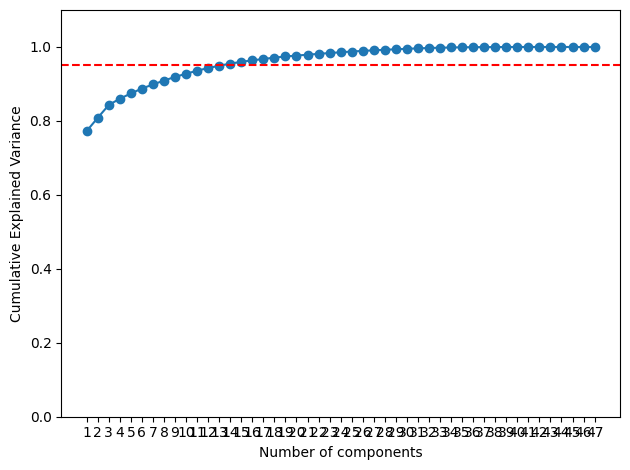

In [ ]:
cumsum_pca = np.cumsum(pca.explained_variance_ratio_)
xi = range(1, len(cumsum_pca)+1)

plt.plot(xi, cumsum_pca,marker='o',linestyle='-')
plt.ylim(0.0,1.1)
plt.xlabel('Number of components')
plt.ylabel("Cumulative Explained Variance")
plt.xticks(xi)
plt.axhline(y=0.95, color='r',linestyle='--')
plt.tight_layout()

In [ ]:
pca = PCA(n_components=14)
transformed_data = pca.fit_transform(clean_df)

explained_variance = np.sum(pca.explained_variance_ratio_) * 100
print(f"Total explained variance with 14 components: {explained_variance:.2f}%")

Total explained variance with 14 components: 95.49%


In [ ]:
pca_df = pd.DataFrame(transformed_data, columns=[f"PC{i+1}" for i in range(14)])
pca_df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0   3.856265 -2.382905  2.022565 -1.540713 -2.120278 -1.142984  0.988018   
1   4.858711 -0.808119  0.645160 -1.366584 -1.846805  0.931787  0.138006   
2   1.835672 -2.779571 -2.127297 -1.395061  0.173584 -0.642874 -0.031003   
3   1.837141  1.471459  3.626619 -1.467605 -1.620189 -0.211541  0.267154   
4  10.780886 -1.154328 -0.525617  1.090024 -0.194073  1.791767 -0.046180   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  
0 -0.531318  1.026451  0.920782 -0.032827  0.075779 -0.586218 -1.102434  
1  0.417321  1.435723 -0.494688 -0.101086 -0.329857 -0.516601  0.523375  
2 -0.147064 -0.477779  0.801925  0.217697 -0.883891 -0.093115  0.655600  
3 -0.180182 -0.463785  1.133343  0.488199 -0.536271  0.280474  0.172007  
4  0.679556  2.374585  1.041631 -0.010206  0.001658 -1.526011 -1.187130

In [ ]:
pca_df.to_csv('pca_df.csv')

In [ ]:
pca_components = pd.DataFrame(pca.components_, columns=clean_df.columns, index=[f'PCA_{i+1}' for i in range(pca.n_components_)])

print("PCA Component Loadings:")
print(pca_components)

PCA Component Loadings:
           grade  num_accts_ever_120_pd  mort_acc  chargeoff_within_12_mths  \
PCA_1  -0.017157              -0.002903 -0.006841                  0.000013   
PCA_2   0.378135               0.023627 -0.219598                  0.000107   
PCA_3   0.499010               0.013688  0.096952                  0.000707   
PCA_4  -0.212713               0.105836  0.299562                  0.002532   
PCA_5   0.334707               0.119052  0.157393                  0.003645   
PCA_6  -0.079356              -0.179972 -0.042234                 -0.004469   
PCA_7  -0.138132               0.109698 -0.098628                  0.002476   
PCA_8   0.045093              -0.077082  0.004805                 -0.002306   
PCA_9  -0.148572               0.180125 -0.298294                  0.003518   
PCA_10  0.071275               0.028545  0.071361                  0.001309   
PCA_11  0.013335              -0.060221 -0.311636                 -0.000434   
PCA_12 -0.104038            

#K-Means

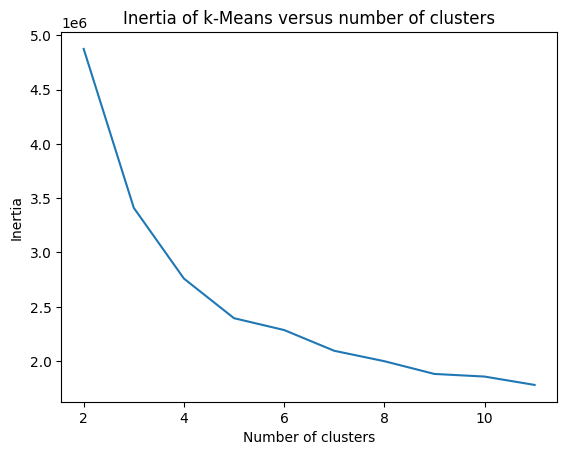

In [ ]:
def elbow_plot(data):
    scores = [KMeans(n_clusters=i+2).fit(data).inertia_
          for i in range(10)]
    sns.lineplot(x=np.arange(2, 12), y=scores)
    plt.xlabel('Number of clusters')
    plt.ylabel("Inertia")
    plt.title("Inertia of k-Means versus number of clusters")

elbow_plot(pca_df)

In [ ]:
range_n_clusters = range(3, 8)
silhouette_scores = {}

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_df)
    score = silhouette_score(pca_df, cluster_labels)
    silhouette_scores[k] = score
    print(f"For n_clusters = {k}, the silhouette score is {score:.4f}")

optimal_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"\nOptimal number of clusters: {optimal_k} with a silhouette score of {silhouette_scores[optimal_k]:.4f}")

For n_clusters = 3, the silhouette score is 0.4194
For n_clusters = 4, the silhouette score is 0.2983
For n_clusters = 5, the silhouette score is 0.2375
For n_clusters = 6, the silhouette score is 0.1755
For n_clusters = 7, the silhouette score is 0.1625

Optimal number of clusters: 3 with a silhouette score of 0.4194


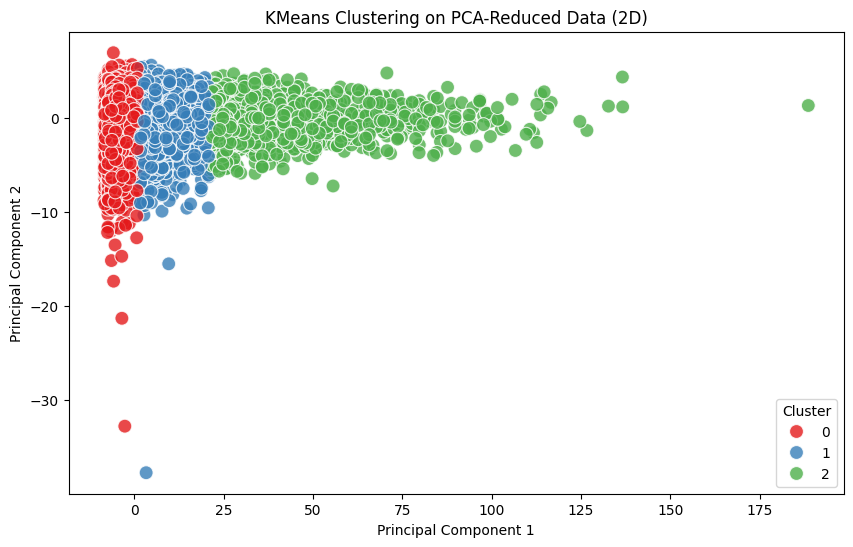

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
pca_df['Cluster'] = kmeans.fit_predict(pca_df)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set1', s=100, alpha=0.8)
plt.title("KMeans Clustering on PCA-Reduced Data (2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.show()

In [ ]:
pca_df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0   3.856265 -2.382905  2.022565 -1.540713 -2.120278 -1.142984  0.988018   
1   4.858711 -0.808119  0.645160 -1.366584 -1.846805  0.931787  0.138006   
2   1.835672 -2.779571 -2.127297 -1.395061  0.173584 -0.642874 -0.031003   
3   1.837141  1.471459  3.626619 -1.467605 -1.620189 -0.211541  0.267154   
4  10.780886 -1.154328 -0.525617  1.090024 -0.194073  1.791767 -0.046180   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -0.531318  1.026451  0.920782 -0.032827  0.075779 -0.586218 -1.102434   
1  0.417321  1.435723 -0.494688 -0.101086 -0.329857 -0.516601  0.523375   
2 -0.147064 -0.477779  0.801925  0.217697 -0.883891 -0.093115  0.655600   
3 -0.180182 -0.463785  1.133343  0.488199 -0.536271  0.280474  0.172007   
4  0.679556  2.374585  1.041631 -0.010206  0.001658 -1.526011 -1.187130   

   Cluster  
0        1  
1        1  
2        1  
3        1  
4        1

#Cluster Analysis

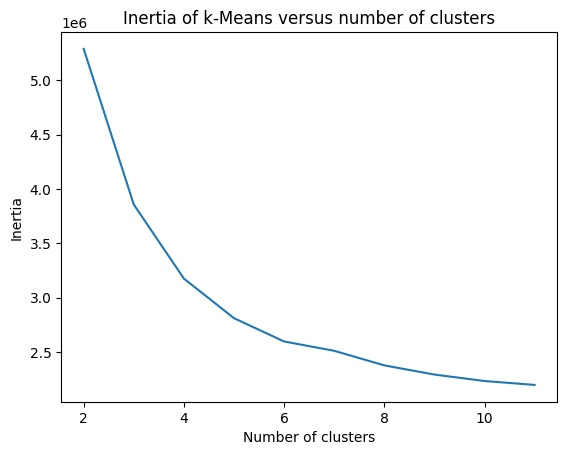

In [ ]:
def elbow_plot(data):
    scores = [KMeans(n_clusters=i+2).fit(data).inertia_
          for i in range(10)]
    sns.lineplot(x=np.arange(2, 12), y=scores)
    plt.xlabel('Number of clusters')
    plt.ylabel("Inertia")
    plt.title("Inertia of k-Means versus number of clusters")

elbow_plot(clean_df)

In [ ]:
range_n_clusters = range(3, 8)

silhouette_scores = {}

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(clean_df)
    score = silhouette_score(clean_df, cluster_labels)
    silhouette_scores[k] = score
    print(f"For n_clusters = {k}, the silhouette score is {score:.4f}")

optimal_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"\nOptimal number of clusters: {optimal_k} with a silhouette score of {silhouette_scores[optimal_k]:.4f}")

For n_clusters = 2, the silhouette score is 0.5473
For n_clusters = 3, the silhouette score is 0.3149
For n_clusters = 4, the silhouette score is 0.2915
For n_clusters = 5, the silhouette score is 0.1819
For n_clusters = 6, the silhouette score is 0.1819
For n_clusters = 7, the silhouette score is 0.1797
For n_clusters = 8, the silhouette score is 0.1576
For n_clusters = 9, the silhouette score is 0.1259
For n_clusters = 10, the silhouette score is 0.1251

Optimal number of clusters: 2 with a silhouette score of 0.5473


In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
clean_df['Cluster'] = kmeans.fit_predict(clean_df)

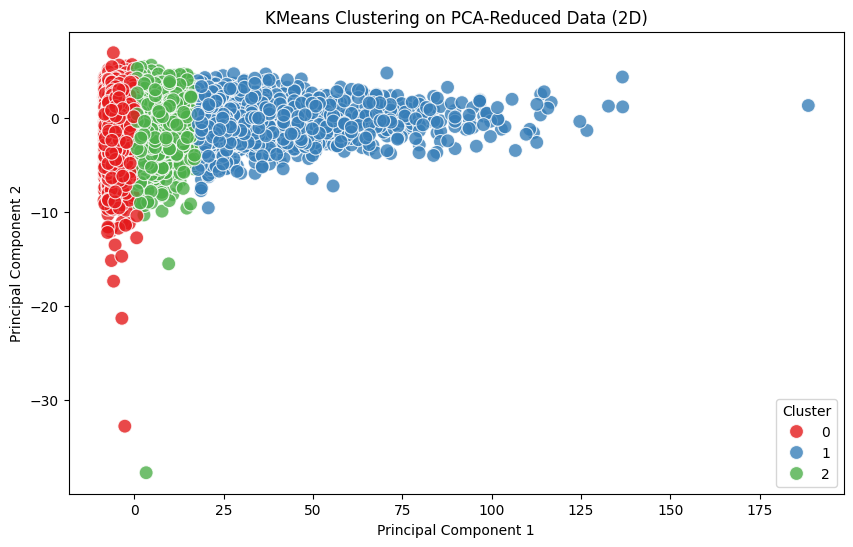

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
pca_df['Cluster'] = clean_df['Cluster']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set1', s=100, alpha=0.8)
plt.title("KMeans Clustering on PCA-Reduced Data (2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.show()

In [ ]:
columns_to_analyze = [
    'grade', 'num_accts_ever_120_pd', 'mort_acc', 'chargeoff_within_12_mths',
    'open_acc_6m', 'collections_12_mths_ex_med', 'pub_rec', 'debt_settlement_flag',
    'hardship_flag', 'verification_status_combined', 'emp_length_1 to 5',
    'emp_length_6 to 10', 'emp_length_Less than 1', 'emp_length_More than 10',
    'home_ownership_MORTGAGE', 'home_ownership_OTHER', 'home_ownership_OWN',
    'home_ownership_RENT', 'loan_status_Charged Off', 'loan_status_Current',
    'loan_status_Fully Paid', 'loan_status_Late', 'purpose_credit_card',
    'purpose_debt_consolidation', 'purpose_other', 'purpose_personal',
    'loan_amnt', 'int_rate', 'installment', 'credit_age', 'total_pymnt',
    'tot_coll_amt', 'credit_utilization', 'bc_open_to_buy', 'pct_tl_nvr_dlq',
    'percent_bc_gt_75', 'high_credit_limit', 'dti_combined',
    'annual_inc_combined', 'total_credit_exposure', 'inq_rate', 'il_rate',
    'rv_rate', 'acc_ratio', 'il_ratio', 'mths_since_op', 'satisfactory_ratio'
]
cluster_means = clean_df.groupby('Cluster')[columns_to_analyze].mean()

overall_means = clean_df[columns_to_analyze].mean()

deviation_from_overall = cluster_means - overall_means

In [ ]:
for cluster in deviation_from_overall.index:
    print(f"\nTop contributing features for Cluster {cluster}:")

    top_positive = deviation_from_overall.loc[cluster].sort_values(ascending=False).head(5)
    print("Top 5 Positive Deviations:")
    print(top_positive)

    top_negative = deviation_from_overall.loc[cluster].sort_values(ascending=True).head(5)
    print("Top 5 Negative Deviations:")
    print(top_negative)


Top contributing features for Cluster 0:
Top 5 Positive Deviations:
open_acc_6m              0.261597
total_credit_exposure    0.141219
rv_rate                  0.120118
grade                    0.105748
int_rate                 0.080810
Name: 0, dtype: float64
Top 5 Negative Deviations:
mths_since_op         -4.114607
percent_bc_gt_75      -0.080639
home_ownership_RENT   -0.021133
loan_amnt             -0.020764
loan_status_Current   -0.020611
Name: 0, dtype: float64

Top contributing features for Cluster 1:
Top 5 Positive Deviations:
mths_since_op       30.025157
percent_bc_gt_75     0.320285
loan_amnt            0.144915
credit_age           0.141755
installment          0.111681
Name: 1, dtype: float64
Top 5 Negative Deviations:
total_credit_exposure   -0.585997
open_acc_6m             -0.530492
rv_rate                 -0.338171
grade                   -0.333073
int_rate                -0.255526
Name: 1, dtype: float64

Top contributing features for Cluster 2:
Top 5 Positive Devia

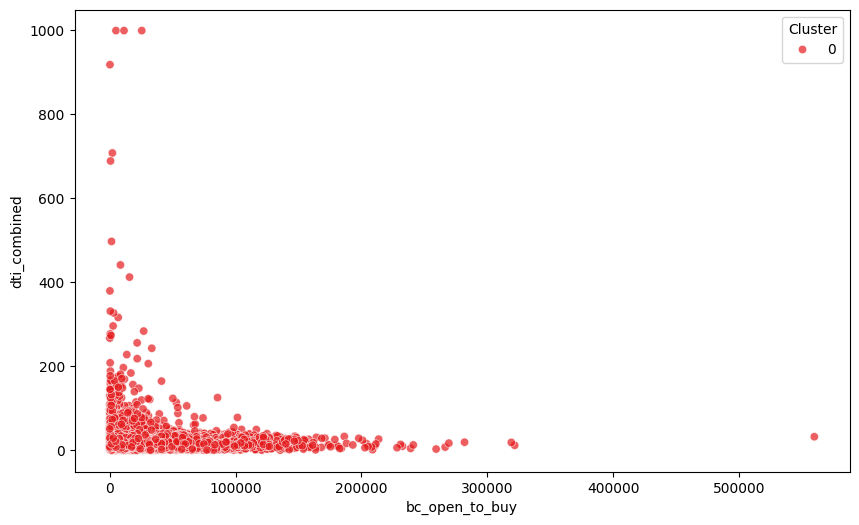

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=main_df[main_df['cluster']==0], x='bc_open_to_buy', y='dti_combined', hue='cluster', palette='Set1', alpha=0.7)
plt.legend(title='Cluster')
plt.show()

In [ ]:
#1:low dti
#2:medium
#0:low bc open
#inverse relationship()

In [ ]:
#0:
#mths_since_op:(0,9)
#1:
#mths:(25,100)
#2:
#mths:(9,25)

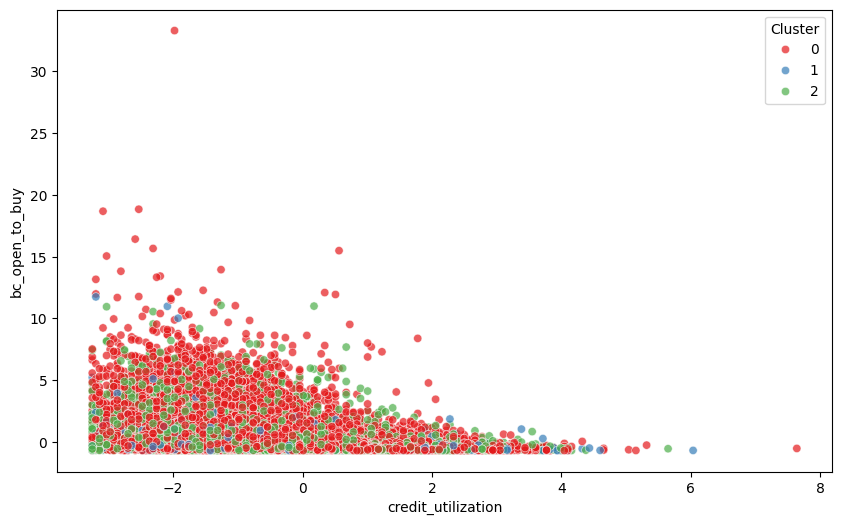

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=clean_df, x='credit_utilization', y='bc_open_to_buy', hue='Cluster', palette='Set1', alpha=0.7)
plt.legend(title='Cluster')
plt.show()

In [ ]:
cluster=clean_df['Cluster']
main_df['cluster']=cluster

In [ ]:
main_df

loan_amnt  term  int_rate  installment  grade    emp_length  \
0        35000.0  36.0     12.12      1164.51    1.0   Less than 1   
1        30000.0  60.0     10.75       648.54    1.0        1 to 5   
2        15000.0  36.0      7.49       466.53    0.0        1 to 5   
3        24000.0  60.0     21.15       651.31    4.0        1 to 5   
4        14400.0  36.0      8.59       455.18    0.0        1 to 5   
...          ...   ...       ...          ...    ...           ...   
99995     4000.0  36.0     13.49       135.73    2.0        1 to 5   
99996    35000.0  60.0     15.59       843.53    3.0       6 to 10   
99997    20000.0  60.0     15.49       480.96    2.0        1 to 5   
99998    16000.0  36.0     11.06       524.28    1.0  More than 10   
99999    10000.0  36.0     13.06       337.23    2.0  More than 10   

      home_ownership loan_status             purpose  credit_age  ...  \
0               RENT  Fully Paid  debt_consolidation   15.591781  ...   
1               RENT     Current         credit_card    4.838356  ...   
2                OWN  Fully Paid               other   20.515068  ...   
3               RENT  Fully Paid  debt_consolidation   15.095890  ...   
4           MORTGAGE     Current  debt_consolidation   12.676712  ...   
...              ...         ...                 ...         ...  ...   
99995           RENT     Current  debt_consolidation    8.756164  ...   
99996       MORTGAGE  Fully Paid  debt_consolidation   14.260274  ...   
99997       MORTGAGE     Current  debt_consolidation   11.673973  ...   
99998       MORTGAGE  Fully Paid  debt_consolidation   15.506849  ...   
99999           RENT     Current  debt_consolidation   15.421918  ...   

       home_ownership_RENT  loan_status_Charged Off  loan_status_Current  \
0                        1                        0                    0   
1                        1                        0                    1   
2                        0                        0                    0   
3                        1                        0                    0   
4                        0                        0                    1   
...                    ...                      ...                  ...   
99995                    1                        0                    1   
99996                    0                        0                    0   
99997                    0                        0                    1   
99998                    0                        0                    0   
99999                    1                        0                    1   

       loan_status_Fully Paid loan_status_Late  purpose_credit_card  \
0                           1                0                    0   
1                           0                0                    1   
2                           1                0                    0   
3                           1                0                    0   
4                           0                0                    0   
...                       ...              ...                  ...   
99995                       0                0                    0   
99996                       1                0                    0   
99997                       0                0                    0   
99998                       1                0                    0   
99999                       0                0                    0   

       purpose_debt_consolidation  purpose_other  purpose_personal  cluster  
0                               1              0                 0        2  
1                               0              0                 0        2  
2                               0              1                 0        2  
3                               1              0                 0        2  
4                               1              0                 0        2  
...                           ...            ...       

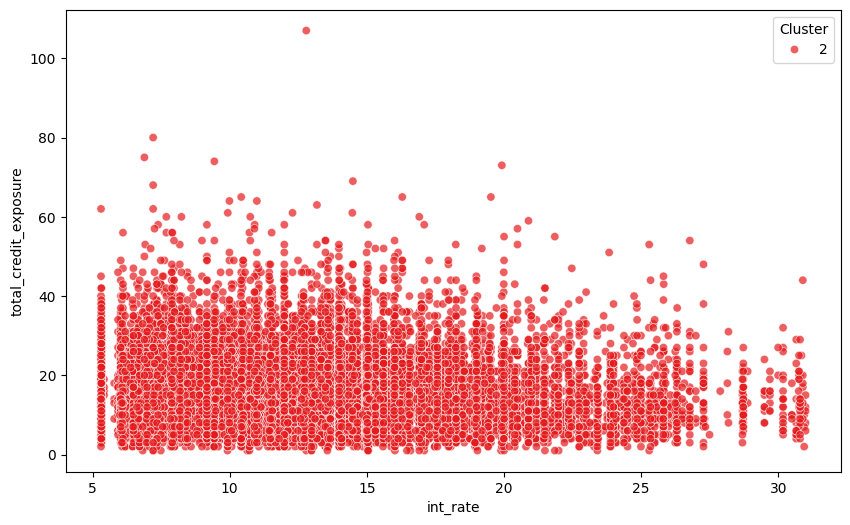

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=main_df[main_df['cluster']==2], x='int_rate', y='total_credit_exposure', hue='cluster', palette='Set1', alpha=0.7)
plt.legend(title='Cluster')
plt.show()

In [ ]:
#0
#credit:(0,100)
#total:(0,60)(80,100)# gradual linear

#1
#credit:(0,100)
#total:(0,25)#steep linear

#2
#credit:(0,100)
#total:(0,40)#




In [ ]:
#0
#credit:(0,125)
#bc_open:(0,150000)

#1
#credit:(20,125)
#bc_open:(0,50000)

#2
#credit:(0,120)
#bc_open:(0,100000)
#dense:(0,60),(0,50000)


In [ ]:

#0:low risk
#1:high risk
#2:medium risk

#Hierarchical

In [ ]:
hierarchical_clustering = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
labels = hierarchical_clustering.fit_predict(pca_df)

In [ ]:
hie_df = pd.DataFrame(pca_df, columns=[f'PC{i+1}' for i in range(pca_df.shape[1])])
hie_df['Cluster'] = labels

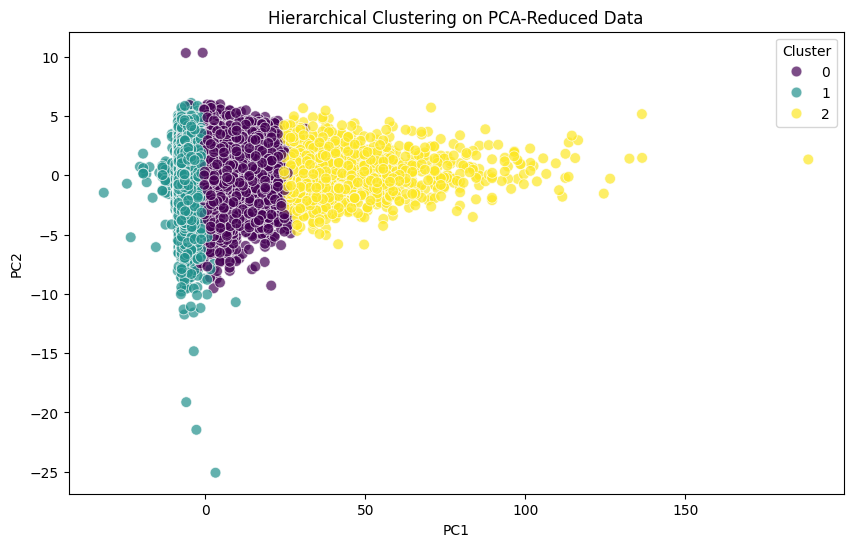

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=hie_df, palette='viridis', s=60, alpha=0.7)
plt.title('Hierarchical Clustering on PCA-Reduced Data')
plt.show()

# DBSCAN

In [ ]:
dbscan = DBSCAN(eps=3, min_samples=4, metric='euclidean')
labels = dbscan.fit_predict(pca_df)

In [ ]:
db_df = pd.DataFrame(pca_df, columns=[f'PC{i+1}' for i in range(pca_df.shape[1])])
db_df['Cluster'] = labels

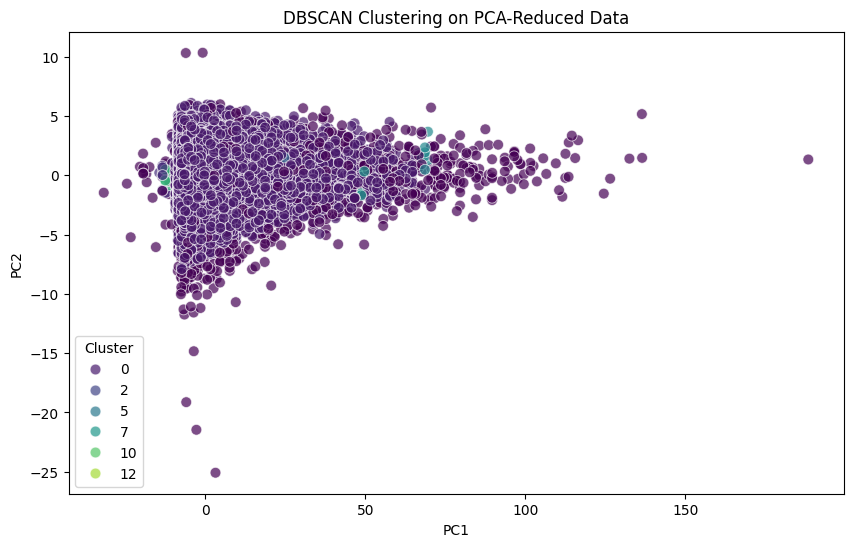

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=db_df, palette='viridis', s=60, alpha=0.7)
plt.title('DBSCAN Clustering on PCA-Reduced Data')
plt.show()

#T-SNE

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(clean_df)

tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])

In [ ]:
tsne_df.head()

TSNE1      TSNE2
0  47.289539 -46.074554
1  57.130978 -33.423588
2  34.099491 -20.035048
3  36.991680 -42.951653
4  80.974380  -4.667554

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(tsne_df)

KMeans(n_clusters=3, random_state=42)

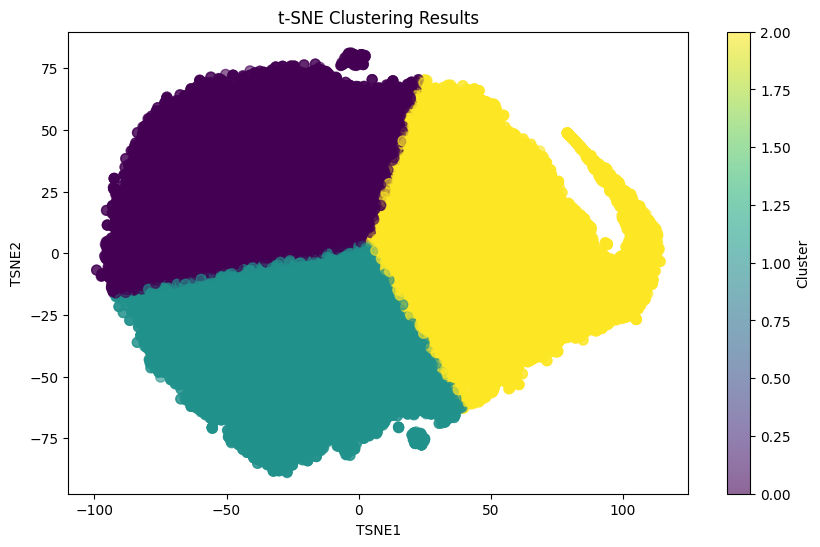

In [ ]:
tsne_df['Cluster'] = kmeans.labels_

plt.figure(figsize=(10, 6))
plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=tsne_df['Cluster'], cmap='viridis', marker='o', s=50, alpha=0.6)
plt.title('t-SNE Clustering Results')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.colorbar(label='Cluster')
plt.show()

#Affinity Prpogation

In [ ]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

In [ ]:
affinity_propagation = AffinityPropagation(random_state=42)
affinity_propagation.fit(pca_df)

In [ ]:
cluster_centers_indices = affinity_propagation.cluster_centers_indices_
labels = affinity_propagation.labels_

In [ ]:
n_clusters = len(cluster_centers_indices)
print(f"Estimated number of clusters: {n_clusters}")